[](数式を楽に表記するための準備)
<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>
<script type="text/x-mathjax-config">
 MathJax.Hub.Config({
 tex2jax: {
 inlineMath: [['$', '$'] ],
 displayMath: [ ['$$','$$'], ["\\[","\\]"] ]
 }
 });
</script>

# ガウス過程に基づく逐次抽出型c-回帰モデル
目的関数と制約条件を以下に記す．
$$
J_{\mathrm{gpscrm}}(\boldsymbol{U}, \boldsymbol{K})=\sum_{k=1}^{n} u_{k 1}\left(y_{k}^{(1)}-\boldsymbol{k}_{*}^{(1) T} \boldsymbol{K}^{(1)-1} \boldsymbol{Y}^{(1)}\right)^{2}+\sum_{k=1}^{n} u_{k_{0}} D
$$

$$
\mathcal{U}_{\mathrm{gpscrm}}=\left\{\left(u_{k i}\right): u_{k i} \in\{0,1\}, \sum_{i=0}^{1} u_{k i}=1,{ }^{\forall} k\right\}
$$

In [1]:
#ライブラリのインポート
%matplotlib inline
import numpy as np
import pandas as pd
import random
import copy
import os
import math
import datetime
import time
import operator
from numpy import sqrt
from tqdm.notebook import tqdm
from scipy import linalg
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True)

In [2]:
#-------------------
class Data:
    def __init__(self,x,y,u,id):
        self.x = x #説明変数
        self.y = y #目的変数
        self.u = u #抽出クラスタかノイズクラスタかどうか
        self.id = id #データごとの番号
        self.cluster_number = 0 #最終的なクラスタ番号
#------------------- 

In [5]:
class GPSCRM:
    #-------------------
    def __init__(self,X,Y,alpha,lam,D,labels,max_iter,random_seed):
        self.X = X
        self.Y = Y        
        self.xx = np.linspace(np.min(X)-1 , np.max(X)+1 , 500)
        self.alpha = alpha
        self.lam = lam
        self.D = D
        self.labels = labels
        self.max_iter = max_iter
        self.random_seed = random_seed
        np.random.seed(random_seed)
    #-------------------
        
    #-------------------
    #クラスタリング結果を出力するメソッド
    def plot(self,path):
        N = self.X.shape[0]
        c = ["b","r","g","c","m","y","k","w"]
        markers = ["o","+","x","v","o", "^", "<", ">"]
        plt.figure(figsize=(5,5))
        plt.xlim(np.min(self.X)-1,np.max(self.X)+1,1)
        plt.ylim(np.min(self.Y)-1,np.max(self.Y)+1,1)
        plt.xlabel("x")
        plt.ylabel("y")
        
        #データ点の散布図のプロット．クラスタごとに色分けして出力する．
        for k in range(len(self.ex_data_list)):
                #クラスタ数が多すぎると，色が重なってわからなくなるので，表示しないようにする．
                if self.ex_data_list[k].cluster_number> 4:
                    break
                plt.scatter(self.ex_data_list[k].x, self.ex_data_list[k].y,marker=markers[self.ex_data_list[k].cluster_number],s=35,c = c[self.ex_data_list[k].cluster_number])
        
        #期待値のプロット．
        for i in range(self.n_cluster):
            #プロットは4つまで
            if i > 4:
                break
            plt.plot(self.xx,model.display_exp_list[i],c=c[i])
        
        #分散のプロット
        for i in range(self.n_cluster):
            #プロットは2つまで．色が重なって訳わかんなくなるので．
            if i > 2:
                break
            plt.fill_between(self.xx,self.display_exp_list[i] - 2 * sqrt(self.display_var_list[i]),self.display_exp_list[i] + 2 * sqrt(self.display_var_list[i]),alpha = 0.5,color=c[i])

        plt.savefig(os.path.join(path)+"figure.png")
        plt.show()
    #-------------------
    
    #-------------------
    #抽出毎のクラスタリング結果をプロットするメソッド
    def sequential_plot(self,exp_list,var_list,data_list):
        X = []
        Y = []
        for i in range(len(data_list)):
            X.append(data_list[i].x)
            Y.append(data_list[i].y)
        X = np.array(X)
        Y = np.array(Y)
        N = X.shape[0]
        x = np.arange(np.amin(X),np.amax(X) + 1)
        std = []
        c = ["r","b"]
        markers = ["+","o"]
        plt.figure(figsize=(5,5))
        plt.xlim(np.min(X)-1,np.max(X)+1,1)
        plt.ylim(np.min(Y)-1,np.max(Y)+1,1)
        plt.xlabel("x")
        plt.ylabel("y")
        for i in range(N):
            plt.scatter(X[i],Y[i],marker=markers[data_list[i].u],s=35,c = c[data_list[i].u])
        #期待値のプロット．
        plt.plot(self.xx,exp_list,c=c[1])
        plt.fill_between(self.xx,exp_list - 2 * sqrt(var_list),exp_list + 2 * sqrt(var_list),alpha = 0.5,color=c[1])
        plt.show()
    #-------------------

    #-------------------
    #カーネル行列を作成する
    def kernel_matrix(self,X):
        n = X.size
        return np.array([self.gauss(xi, xj) for xi in X for xj in X]).reshape(n, n)
    #-------------------

    #-------------------
    #カーネルベクトルを作成する
    def calc_k_a(self,X,xx):
        N = len(X)
        k_a = np.zeros(N)
        for i in range(N):
            k_a[i] = self.gauss(X[i],xx)
        return k_a
    #-------------------

    #-------------------
    #帰属度Uを更新する．非類似度とノイズパラメータを比較して，帰属度を決定する．
    def update_U(self,data_list,noise_param,exp_list):
        for i in range(len(data_list)):
            distance = (data_list[i].y - exp_list[i])**2
            if distance <= noise_param:
                data_list[i].u = 1
            else:
                data_list[i].u = 0
    #-------------------
    
    #-------------------
    #data__listを昇順にソートする
    def sort_ex_data_list(self):
        N = len(self.ex_data_list)
        for i in range(N):
            swap = False
            for j in range(N-1,i,-1):
                if self.ex_data_list[j-1].id > self.ex_data_list[j].id:
                    self.ex_data_list[j-1],self.ex_data_list[j] = self.ex_data_list[j],self.ex_data_list[j-1]
                    swap = True
            if swap == False:
                break
    #-------------------
    
    #-------------------
    #ARIを計算するメソッド
    def calc_ARI(self):
        #dataIDに基づいて，ex_data_listをソートする．
        self.sort_ex_data_list()
        N = len(self.ex_data_list)
        predict_labels = np.zeros([N])
        for k in range(N):
                predict_labels[k] = self.ex_data_list[k].cluster_number
        # print("正解ラベル",self.labels)
        # print(self.labels.shape)
        # print("U_list:",predict_labels)
        # print(predict_labels.shape)
    
        #predict = []
        #predicted_label = np.argmax(U,axis=0)
        ARI = adjusted_rand_score(self.labels,predict_labels)
        return ARI
    #-------------------
    
    #-------------------
    #MAEを計算する．
    def calc_MAE(self,data_list,exp_list):
        y_true = []
        y_pred = []
        for i in range(len(data_list)):
            if(data_list[i].u == 1):
                y_true.append(data_list[i].y)
                y_pred.append(exp_list[i])
        if len(y_true) == 0:
            return np.nan
        return np.sqrt(mean_absolute_error(y_true, y_pred))
    #-------------------
    
    #-------------------
    #RMSEを計算する
    def calc_RMSE(self,data_list,exp_list):
        y_true = []
        y_pred = []
        for i in range(len(data_list)):
            if(data_list[i].u == 1):
                y_true.append(data_list[i].y)
                y_pred.append(exp_list[i])
        if len(y_true) == 0:
            return np.nan
        return np.sqrt(mean_squared_error(y_true, y_pred))
    #-------------------
    
    #-------------------
    #決定係数を計算する
    def calc_r2_score(self,data_list,exp_list):
        y_true = []
        y_pred = []
        for i in range(len(data_list)):
            if(data_list[i].u == 1):
                y_true.append(data_list[i].y)
                y_pred.append(exp_list[i])
        if len(y_true) == 0:
            return np.nan
        return r2_score(y_true, y_pred) 
    #-------------------
    
    #-------------------
    #収束したかどうか確認する
    def calc_is_convergence(self,pre_data_list,data_list):
        N = len(data_list)
        pre_U = np.zeros([N])
        U = np.zeros([N])
        for k in range(N):
            pre_U[k] = pre_data_list[k].u
            U[k] = data_list[k].u
        return all(pre_U == U)
    #-------------------
    
    #-------------------
    def print_info(self,model,time):
        print("クラスタ数:",model.n_cluster)
        print("ARIの値:",model.ARI)
        print("RMSEの値:",model.RMSE_list)
        print("MAEの値:",model.MAE_list)
        print("r2scoreの値:",model.r2_score_list)
        print("実行時間:",time) 
        print("")
    #-------------------
    
    #-------------------
    def log_save(self,path,model,time):
        d_today = datetime.date.today()
        d_now = datetime.datetime.now() 
        f = open(path +"log.txt", 'w')
        f.write("実験に使用した記録まとめ\n")
        f.write(str(d_now) + "\n")
        f.write("クラスタ数:" + str(model.n_cluster) + "\n")
        f.write("ARIの値:" + str(model.ARI) + "\n")
        f.write("RMSEの値:" + str(model.RMSE_list) + "\n")
        f.write("MAEの値:" + str(model.MAE_list) + "\n")
        f.write("R2score(決定係数)の値:" + str(model.r2_score_list) + "\n")
        f.write("実行時間:" + str(time) + "\n")
        f.write("random_seed値:" + str(model.random_seed) +"\n") 
        f.write("ノイズパラメータD:" + str(model.D) + "\n")
        f.write("カーネルパラメータα:" + str(model.alpha) + "\n")
        f.write("正則化パラメータλ:" + str(model.lam) +"\n")
        f.close()
    #-------------------
    
    #-------------------
    def extract_cluster_data(self,data_list):
        c_x = []
        c_y = []
        for i in range(len(data_list)):
            if data_list[i].u == 1:
                c_x.append(data_list[i].x)
                c_y.append(data_list[i].y)
        c_x = np.array(c_x)
        c_y = np.array(c_y)
        return c_x,c_y
    #-------------------
    
    #-------------------
    def gp_calc_exp_var(self,data_list):
        N = len(data_list)
        exp_list = np.zeros(N)
        var_list = np.zeros(N)
        X = np.zeros(N)
        for i in range(N):
            X[i] = data_list[i].x
        #抽出クラスタに属するデータのみを集めたリスト
        c_x , c_y = self.extract_cluster_data(data_list)
        K = self.kernel_matrix(c_x)
        k_inv_ridge = np.linalg.inv(K + self.lam * np.eye(len(c_x)))
        #k_inv_ridge = np.linalg.inv(K)
        for i,x in enumerate (X):
            k_a = self.calc_k_a(c_x,x)
            k_aa = self.gauss(x,x) + self.lam
            exp_list[i] = k_a.T @ k_inv_ridge @ c_y
            var_list[i] = k_aa - k_a.T @ k_inv_ridge @ k_a
        return exp_list,var_list
    #------------------
    
    #-------------------
    def display_calc(self,data_list):
        exp_list = np.zeros(self.xx.shape)
        var_list = np.zeros(self.xx.shape)
        #抽出クラスタに属するデータのみを集めたリスト
        c_x , c_y = self.extract_cluster_data(data_list)
        K = self.kernel_matrix(c_x)
        k_inv_ridge = np.linalg.inv(K + self.lam * np.eye(len(c_x)))
        #k_inv_ridge = np.linalg.inv(K)
        for i,x in enumerate (self.xx):
            k_a = self.calc_k_a(c_x,x)
            k_aa = self.gauss(x,x) + self.lam
            exp_list[i] = k_a.T @ k_inv_ridge @ c_y
            var_list[i] = k_aa - k_a.T @ k_inv_ridge @ k_a
        return exp_list,var_list
    #------------------
    
    #-------------------
    def fit(self):
        self.ex_data_list = []
        self.display_exp_list = []
        self.display_var_list = []
        self.ex_U_list = []
        self.n_cluster = 0
        self.MAE_list = []
        self.RMSE_list = []
        self.r2_score_list = []
        self.ARI = 0
        
        noise_param = 0
        cluster_number = 0
        is_init_noise_param = False
        
        #data_listを作成．ここで，Dataクラスを初期化する．
        data_list = []
        for i in range(self.X.shape[0]):
            data = Data(self.X[i],self.Y[i],np.random.randint(2),i)
            data_list.append(data)
        
        count = 0
        while count < self.max_iter:
            
            #print("データの長さ",len(data_list))
            N = len(data_list)
            is_convergence = False
            noise_data_list = []
            exp_list = []
            var_list = []
            display_exp_list = []
            display_var_list = []
            
            #帰属度を0か1に設定
            #0:ノイズクラスタ
            #1:抽出クラスタ
            for i in range(N):
                data_list[i].u = np.random.randint(2)
            
            for i in range(self.max_iter):
                exp_list,var_list = self.gp_calc_exp_var(data_list)
                
                if is_init_noise_param == False:
                    noise_param = self.calc_noise_param(data_list,exp_list,noise_param)
                    is_init_noise_param = True
                
                #pre_data_list = data_list
                self.update_U(data_list,noise_param,exp_list)
                #is_convergence = self.calc_is_convergence(pre_data_list,data_list)
               
            #収束するまで，期待値と分散の更新を行う
#             while is_convergence == False:
#                 exp_list,var_list = self.gp_calc_exp_var(data_list)
                
#                 if is_init_noise_param == False:
#                     noise_param = self.calc_noise_param(data_list,exp_list,noise_param)
#                     is_init_noise_param = True
                
#                 pre_data_list = data_list
#                 self.update_U(data_list,noise_param,exp_list)
#                 is_convergence = self.calc_is_convergence(pre_data_list,data_list)
                
            #出力用の期待値と分散を計算
            display_exp_list,display_var_list = self.display_calc(data_list)
            #ノイズパラメータを更新
            noise_param = self.calc_noise_param(data_list,exp_list,noise_param) 
            
            #抽出クラスタに属するデータのみを取り出す
            for i in range(N):
                #u=0の場合，仮のリストに保存
                if data_list[i].u == 0:
                    noise_data_list.append(data_list[i])
                #u=1の場合，クラスタ番号を登録して抽出．
                if data_list[i].u == 1:
                    data_list[i].cluster_number = cluster_number
                    self.ex_data_list.append(data_list[i])
            
            #何も抽出しない場合は，クラスタ番号を登録しない．
            if not len(noise_data_list) == len(data_list):
                #期待値と分散のリストを，出力用リストに格納
                self.display_exp_list.append(display_exp_list)
                self.display_var_list.append(display_var_list)
                self.MAE_list.append(self.calc_MAE(data_list,exp_list))
                self.RMSE_list.append(self.calc_RMSE(data_list,exp_list))
                self.r2_score_list.append(self.calc_r2_score(data_list,exp_list))
                #self.sequential_plot(display_exp_list,display_var_list,data_list)
                self.n_cluster += 1
                cluster_number += 1
                
            data_list = noise_data_list
            
            if len(data_list) == 0:
                break
            #抽出ごとにalphaを2倍する
            #alpha = alpha * 2
            #lam = lam/2
            count += 1
            
        #ARIを計算する．
        self.ARI = self.calc_ARI()
    #-------------------
      
    #-------------------
    def calc_noise_param(self,data_list,exp_list,noise_param):
        residual_sum = 0
        for i in range(len(data_list)):
            if data_list[i].u == 1:
                residual_sum += (data_list[i].y - exp_list[i])**2
            else:
                residual_sum += noise_param
        return self.D * residual_sum / len(data_list)    
    #-------------------
    
    #-------------------
    # gaussカーネル
    def gauss(self,x1,x2):
        return np.exp((-1 * self.alpha *(np.sum(x1 - x2)**2)) )
    #-------------------
    
    
    
    #-------------------

In [4]:
def D_plot(X,Y,alpha,lam,D_list,labels,main_path,max_iter,seed):
    ARI_list = []
    ex_RMSE_list = []
    ex_MAE_list = []
    count = 0
    for i in tqdm(range(len(D_list))):
            #print(str(count + 1) + "回目の実行") 
            t1 = time.time()
            model = GPSCRM(X,Y,alpha[0],lam[0],D_list[i],labels,max_iter,seed)
            model.fit()
            t2 = time.time()
            path = make_path(model,main_path)
            model.plot(path)
            model.print_info(model,t2-t1)
            ARI_list.append(model.ARI)
            ex_RMSE_list.append(model.RMSE_list)
            ex_MAE_list.append(model.MAE_list)
            #ex_r2_score_list.append(model.r2_score_list)
            #time_list.append(t2 - t1)
            model.log_save(path,model,t2-t1)
    
    my_makedirs(main_path + "/" + "D"+ str(D_list[0]) + "-" + str(D_list[len(D_list)-1]) +  "alpha" + str(alpha[0]) + "lam" + str(lam[0]))
    path = main_path + "/" + "D"+ str(D_list[0]) + "-" + str(D_list[len(D_list)-1]) + "alpha" + str(alpha[0]) + "lam" + str(lam[0])+"/"        
    plot(D_list,ARI_list,"D","ARI",path)
    RMSE_plot(D_list,"D",ex_RMSE_list,path)
    return ARI_list,ex_RMSE_list,ex_MAE_list
    
def alpha_plot(X,Y,alpha_list,lam,D,labels,main_path,max_iter,seed):
    ARI_list = []
    ex_RMSE_list = []
    ex_MAE_list = []
    #count = 0
    for i in tqdm(range(len(alpha_list))):
        #print(str(count+1) + "回目の実行") 
        t1 = time.time()
        model = GPSCRM(X,Y,alpha_list[i],lam[0],D[0],labels,max_iter,seed)
        model.fit()
        t2 = time.time()
        path = make_path(model,main_path)
        model.plot(path)
        model.print_info(model,t2-t1)
        ARI_list.append(model.ARI)
        ex_RMSE_list.append(model.RMSE_list)
        ex_MAE_list.append(model.MAE_list)
        model.log_save(path,model,t2-t1)
    
#     my_makedirs(main_path + "/" + "alpha"+ str(alpha_list[0]) + "-" + str(alpha_list[len(alpha_list)-1]) +  "lam" + str(lam[0]) + "D" + str(D[0]))
#     path = main_path + "/" + "alpha"+ str(alpha_list[0]) + "-" + str(alpha_list[len(alpha_list)-1]) + "lam" +  str(lam[0]) + "D" + str(D[0])+"/"        
#     plot(alpha_list,ARI_list,"Alpha","ARI",main_path)
#     RMSE_plot(alpha_list,"Alpha",ex_RMSE_list,main_path)
    
    return ARI_list,ex_RMSE_list,ex_MAE_list


def lam_plot(X,Y,alpha,lam_list,D,labels,main_path,max_iter,seed):
    ARI_list = []
    ex_RMSE_list = []
    ex_MAE_list = []
    #count = 0
    for i in tqdm(range(len(lam_list))):
        #print(str(count + 1) + "回目の実行") 
        t1 = time.time()
        model = GPSCRM(X,Y,alpha[0],lam_list[i],D[0],labels,max_iter,seed)
        model.fit()
        t2 = time.time()
        path = make_path(model,main_path)
        model.plot(path)
        model.print_info(model,t2-t1)
        ARI_list.append(model.ARI)
        ex_RMSE_list.append(model.RMSE_list)
        ex_MAE_list.append(model.MAE_list)
        #ex_r2_score_list.append(model.r2_score_list)
        #time_list.append(t2 - t1)
        model.log_save(path,model,t2-t1)
        
    my_makedirs(main_path + "/" + "lam"+ str(lam_list[0]) + "-" + str(lam_list[len(lam_list)-1]) +  "alpha" + str(alpha[0]) + "D" + str(D[0]))
    path = main_path + "/" + "lam"+ str(lam_list[0]) + "-" + str(lam_list[len(lam_list)-1]) + "alpha" + str(alpha[0]) + "D" + str(D[0])+"/"
    plot(lam_list,ARI_list,"Lambda","ARI",path)
    RMSE_plot(lam_list,"Lambda",ex_RMSE_list,path)

    return ARI_list,ex_RMSE_list,ex_MAE_list

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

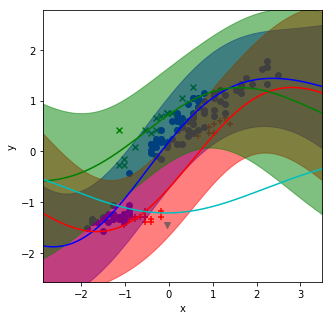

クラスタ数: 4
ARIの値: 0.04215517453013817
RMSEの値: [0.23195992639813776, 0.17303381529242565, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.43907340596201017, 0.3656448066917663, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9456680019593142, 0.9550860046425017, 0.8129628024260871, 0.0]
実行時間: 9.173431873321533



  0%|          | 0/1 [00:00<?, ?it/s]

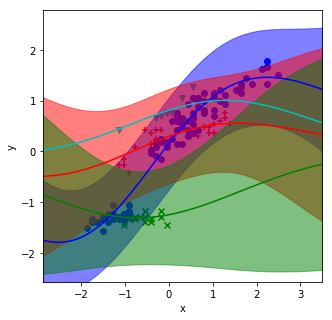

クラスタ数: 4
ARIの値: 0.12005820914767812
RMSEの値: [0.20851028309439562, 0.16440482025230702, 0.08437963583850182, 0.1306313729838254]
MAEの値: [0.4172675850639914, 0.3574625014036282, 0.25406410223949993, 0.30019624271148737]
r2scoreの値: [0.9580989614607203, 0.7185925759116996, -0.1212311399078907, 0.6706903409252489]
実行時間: 8.576957941055298



  0%|          | 0/1 [00:00<?, ?it/s]

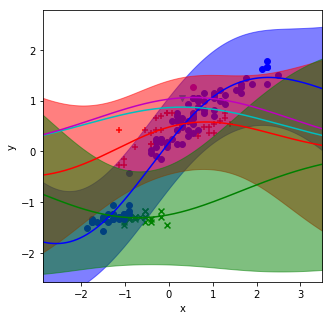

クラスタ数: 5
ARIの値: 0.08906443842652263
RMSEの値: [0.2147211359339366, 0.21860158816364378, 0.08437963583850182, 0.17451452713146087, 0.21242499645762902]
MAEの値: [0.42285232195529404, 0.4310007568196545, 0.25406410223949993, 0.4177493592232798, 0.4608958629209304]
r2scoreの値: [0.9548103409538385, 0.4583752135666065, -0.1212311399078907, 0.0, 0.0]
実行時間: 8.749649047851562



  0%|          | 0/1 [00:00<?, ?it/s]

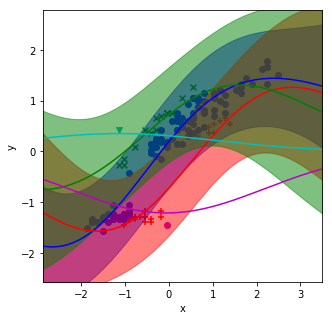

クラスタ数: 5
ARIの値: 0.046798515989786814
RMSEの値: [0.22901682294107167, 0.1704177570206331, 0.1264429865603285, 0.07026073648449821, 0.24250063545638967]
MAEの値: [0.4361218486813688, 0.3613761589876043, 0.3337347358806185, 0.26506741875322626, 0.49244353529759094]
r2scoreの値: [0.9463206648658692, 0.9557479097488686, 0.9206316997175471, 0.0, 0.0]
実行時間: 9.14846158027649



  0%|          | 0/1 [00:00<?, ?it/s]

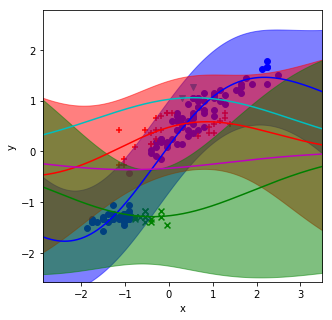

クラスタ数: 5
ARIの値: 0.05590743609650312
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.175633907318115



  0%|          | 0/1 [00:00<?, ?it/s]

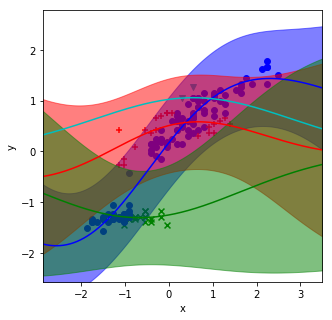

クラスタ数: 4
ARIの値: 0.051349695163116306
RMSEの値: [0.24017611091551308, 0.22223460782702356, 0.09067085013469516, 0.15298800258011977]
MAEの値: [0.4469649818675066, 0.43510246691843424, 0.26552899739278646, 0.33240995395576106]
r2scoreの値: [0.9432878485240055, 0.483069846349094, -0.1303658321477814, -0.8094805431611596]
実行時間: 9.375730991363525



  0%|          | 0/1 [00:00<?, ?it/s]

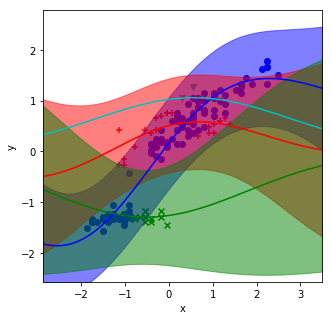

クラスタ数: 4
ARIの値: 0.04642407881809584
RMSEの値: [0.24296375452264843, 0.22223460782702356, 0.084372820281187, 0.15298800258011977]
MAEの値: [0.4496033909664691, 0.43510246691843424, 0.25260907085804973, 0.33240995395576106]
r2scoreの値: [0.9426673250617518, 0.483069846349094, -0.12040818471561088, -0.8094805431611596]
実行時間: 9.184565305709839



  0%|          | 0/1 [00:00<?, ?it/s]

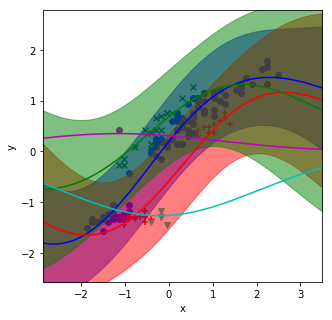

クラスタ数: 5
ARIの値: 0.054756459377874996
RMSEの値: [0.20386179579261726, 0.14856810707542084, 0.15061645435011098, 0.1278194929582779, 0.07026073648449821]
MAEの値: [0.41095195214054286, 0.3352849977876324, 0.36457953779634206, 0.3331137460977132, 0.26506741875322626]
r2scoreの値: [0.9582300987615198, 0.970795845336932, 0.8740331726651883, -0.3701285368263558, 0.0]
実行時間: 8.454777956008911



  0%|          | 0/1 [00:00<?, ?it/s]

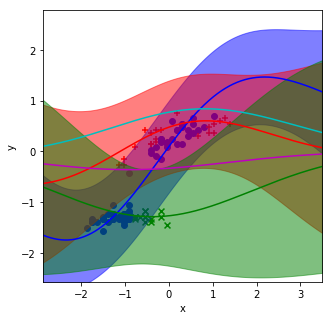

クラスタ数: 6
ARIの値: 0.06881725012755997
RMSEの値: [0.22317996070527346, 0.20306340604489226, 0.08700294713982068, 0.17604786737407943, 0.07190352348863266, 0.21242499645762902]
MAEの値: [0.43412064347332235, 0.4202238937690791, 0.25751029658961355, 0.40019922558072274, 0.26814832367298636, 0.4608958629209304]
r2scoreの値: [0.9552615770331758, 0.5515138831942499, -0.07952879140110203, 0.6831634192165038, 0.0, 0.0]
実行時間: 8.94395899772644



  0%|          | 0/1 [00:00<?, ?it/s]

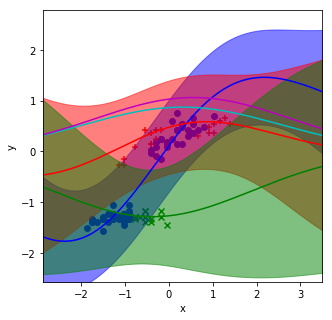

クラスタ数: 6
ARIの値: 0.05567656441028094
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.17451452713146087, 0.21242499645762902, 0.07190352348863266]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.4177493592232798, 0.4608958629209304, 0.26814832367298636]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, 0.0, 0.0, 0.0]
実行時間: 9.141456127166748



  0%|          | 0/1 [00:00<?, ?it/s]

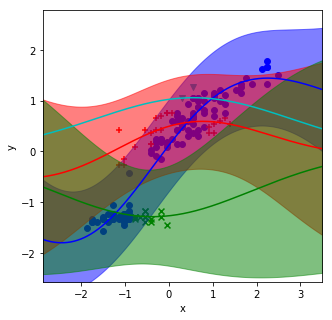

クラスタ数: 4
ARIの値: 0.045949491335736725
RMSEの値: [0.24326835926520424, 0.21686640102782406, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4515671698048527, 0.4269768837592038, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9444403138409554, 0.4965540332458964, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.273785591125488



  0%|          | 0/1 [00:00<?, ?it/s]

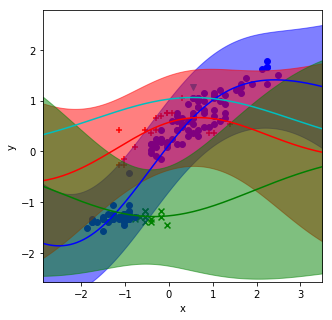

クラスタ数: 4
ARIの値: 0.019846970217546545
RMSEの値: [0.2719744229861532, 0.2448851447404549, 0.09410986993126476, 0.21242499645762902]
MAEの値: [0.47716007524374043, 0.46544735766828976, 0.27548101124297586, 0.4608958629209304]
r2scoreの値: [0.9278217048025297, 0.5467646290891927, -0.08648909921332137, 0.0]
実行時間: 9.643056392669678



  0%|          | 0/1 [00:00<?, ?it/s]

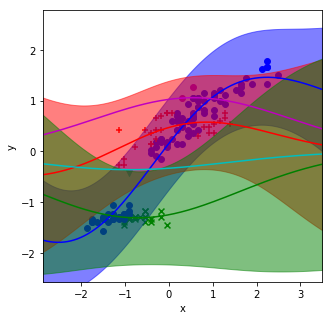

クラスタ数: 5
ARIの値: 0.09602483850944553
RMSEの値: [0.20851028309439562, 0.21680907583646744, 0.08437963583850182, 0.07190352348863266, 0.15298800258011977]
MAEの値: [0.4172675850639914, 0.4294967104657504, 0.25406410223949993, 0.26814832367298636, 0.33240995395576106]
r2scoreの値: [0.9580989614607203, 0.45345940802689877, -0.1212311399078907, 0.0, -0.8094805431611596]
実行時間: 8.74776554107666



  0%|          | 0/1 [00:00<?, ?it/s]

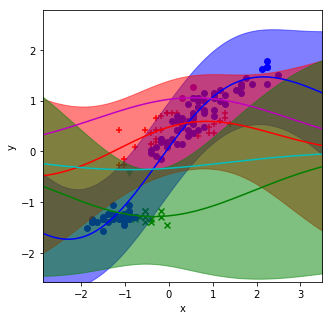

クラスタ数: 5
ARIの値: 0.06282078705992782
RMSEの値: [0.2293111822664583, 0.2187256275660371, 0.09410986993126476, 0.07190352348863266, 0.15298800258011977]
MAEの値: [0.43919450632265483, 0.4352318952159882, 0.27548101124297586, 0.26814832367298636, 0.33240995395576106]
r2scoreの値: [0.9532542382968769, 0.4610999987918568, -0.08648909921332137, 0.0, -0.8094805431611596]
実行時間: 9.117022275924683



  0%|          | 0/1 [00:00<?, ?it/s]

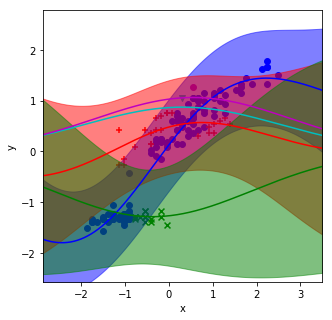

クラスタ数: 5
ARIの値: 0.0503997916335332
RMSEの値: [0.23945475038076008, 0.22099004439210915, 0.08700294713982068, 0.17451452713146087, 0.21242499645762902]
MAEの値: [0.4477211209848282, 0.43311958859702226, 0.25751029658961355, 0.4177493592232798, 0.4608958629209304]
r2scoreの値: [0.9466288676454443, 0.45753047247072387, -0.07952879140110203, 0.0, 0.0]
実行時間: 9.297019243240356



  0%|          | 0/1 [00:00<?, ?it/s]

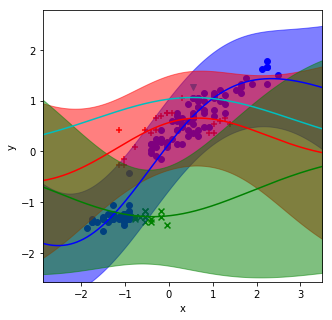

クラスタ数: 4
ARIの値: 0.032036633808868335
RMSEの値: [0.2555956748933826, 0.22849390725008134, 0.08700294713982068, 0.21242499645762902]
MAEの値: [0.4615425159004519, 0.4403420759994469, 0.25751029658961355, 0.4608958629209304]
r2scoreの値: [0.9366081464049067, 0.5533738031821928, -0.07952879140110203, 0.0]
実行時間: 9.431474447250366



  0%|          | 0/1 [00:00<?, ?it/s]

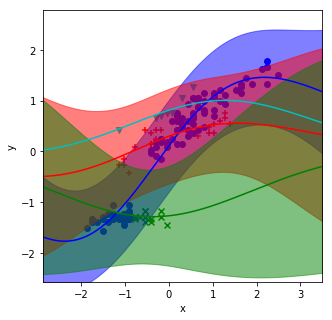

クラスタ数: 4
ARIの値: 0.0776358539060097
RMSEの値: [0.2289204841480767, 0.16812062277406575, 0.08700294713982068, 0.1306313729838254]
MAEの値: [0.4386322972764925, 0.36482004246174804, 0.25751029658961355, 0.30019624271148737]
r2scoreの値: [0.9522464637237278, 0.7136252851541016, -0.07952879140110203, 0.6706903409252489]
実行時間: 8.984766244888306



  0%|          | 0/1 [00:00<?, ?it/s]

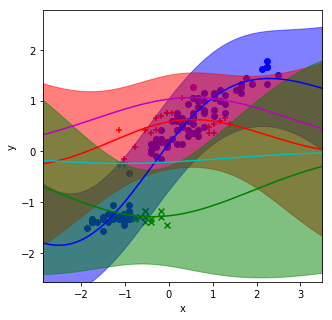

クラスタ数: 5
ARIの値: 0.031070946155976435
RMSEの値: [0.2521236064585579, 0.20604490722127775, 0.08700294713982068, 0.02372709797037688, 0.21242499645762902]
MAEの値: [0.45822214307448117, 0.41251667088820404, 0.25751029658961355, 0.15403602815697656, 0.4608958629209304]
r2scoreの値: [0.938769642163683, 0.3604317906648785, -0.07952879140110203, 0.0, 0.0]
実行時間: 9.559409379959106



  0%|          | 0/1 [00:00<?, ?it/s]

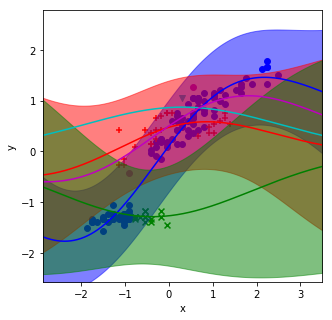

クラスタ数: 5
ARIの値: 0.05555848301429891
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.17451452713146087, 0.43880903611883487]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.4177493592232798, 0.6609072692940092]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, 0.0, 0.7353525180521567]
実行時間: 9.174156665802002



  0%|          | 0/1 [00:00<?, ?it/s]

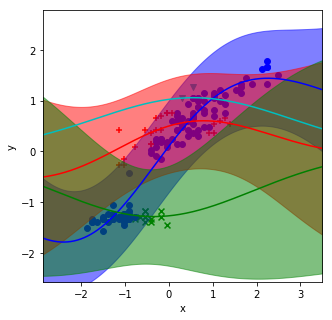

クラスタ数: 4
ARIの値: 0.03554159998105177
RMSEの値: [0.25332858628892896, 0.2197235036128093, 0.09410986993126476, 0.15298800258011977]
MAEの値: [0.460755876253854, 0.4304587795058361, 0.27548101124297586, 0.33240995395576106]
r2scoreの値: [0.9400149301419216, 0.5034059680828378, -0.08648909921332137, -0.8094805431611596]
実行時間: 9.575791835784912



  0%|          | 0/1 [00:00<?, ?it/s]

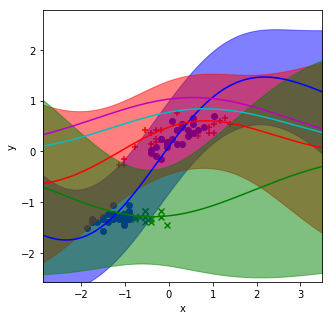

クラスタ数: 6
ARIの値: 0.06881725012755997
RMSEの値: [0.22317996070527346, 0.20306340604489226, 0.08700294713982068, 0.17604786737407943, 0.21242499645762902, 0.07190352348863266]
MAEの値: [0.43412064347332235, 0.4202238937690791, 0.25751029658961355, 0.40019922558072274, 0.4608958629209304, 0.26814832367298636]
r2scoreの値: [0.9552615770331758, 0.5515138831942499, -0.07952879140110203, 0.6831634192165038, 0.0, 0.0]
実行時間: 9.190471649169922



  0%|          | 0/1 [00:00<?, ?it/s]

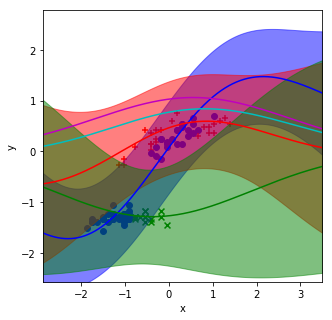

クラスタ数: 6
ARIの値: 0.09119745852588743
RMSEの値: [0.2138901274433633, 0.2023434115038082, 0.08700294713982068, 0.17604786737407943, 0.21242499645762902, 0.07190352348863266]
MAEの値: [0.4253980702700273, 0.4198311955623575, 0.25751029658961355, 0.40019922558072274, 0.4608958629209304, 0.26814832367298636]
r2scoreの値: [0.9599195055872627, 0.5403641134829227, -0.07952879140110203, 0.6831634192165038, 0.0, 0.0]
実行時間: 9.052514791488647



  0%|          | 0/1 [00:00<?, ?it/s]

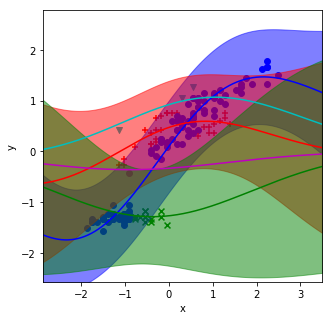

クラスタ数: 5
ARIの値: 0.07621126830904018
RMSEの値: [0.21984324898983945, 0.2013267452021103, 0.08700294713982068, 0.15745708238245862, 0.07190352348863266]
MAEの値: [0.43047605708890757, 0.41826551779157556, 0.25751029658961355, 0.3699396756481691, 0.26814832367298636]
r2scoreの値: [0.9569350569273745, 0.5441755890839617, -0.07952879140110203, 0.8093848133820433, 0.0]
実行時間: 9.069031715393066



  0%|          | 0/1 [00:00<?, ?it/s]

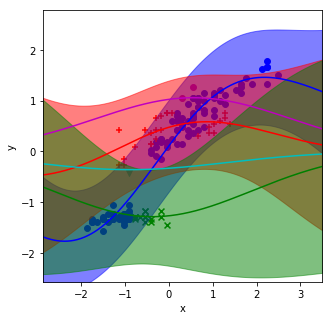

クラスタ数: 5
ARIの値: 0.05590743609650312
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.07190352348863266, 0.15298800258011977]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.26814832367298636, 0.33240995395576106]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, 0.0, -0.8094805431611596]
実行時間: 9.252791166305542



  0%|          | 0/1 [00:00<?, ?it/s]

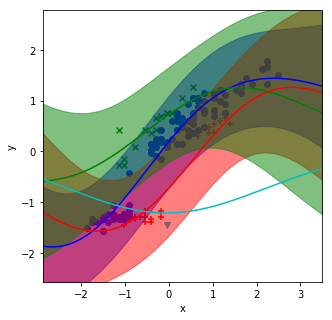

クラスタ数: 4
ARIの値: 0.047829952562327284
RMSEの値: [0.22901682294107167, 0.1704177570206331, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.4361218486813688, 0.3613761589876043, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9463206648658692, 0.9557479097488686, 0.8129628024260871, 0.0]
実行時間: 9.244171857833862



  0%|          | 0/1 [00:00<?, ?it/s]

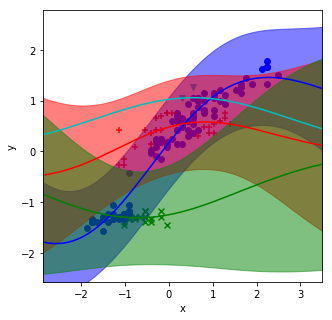

クラスタ数: 4
ARIの値: 0.0893003027681139
RMSEの値: [0.2147211359339366, 0.21860158816364378, 0.08437963583850182, 0.15298800258011977]
MAEの値: [0.42285232195529404, 0.4310007568196545, 0.25406410223949993, 0.33240995395576106]
r2scoreの値: [0.9548103409538385, 0.4583752135666065, -0.1212311399078907, -0.8094805431611596]
実行時間: 8.987196207046509



  0%|          | 0/1 [00:00<?, ?it/s]

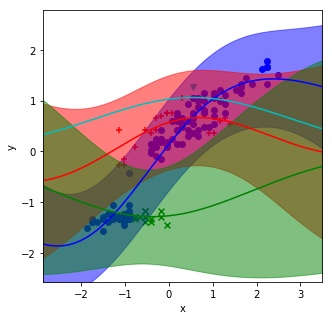

クラスタ数: 4
ARIの値: 0.029899209003237004
RMSEの値: [0.25906616475430494, 0.23284267873475334, 0.08700294713982068, 0.21242499645762902]
MAEの値: [0.4648596530742897, 0.4463185990343918, 0.25751029658961355, 0.4608958629209304]
r2scoreの値: [0.9344263975506912, 0.5570461813080183, -0.07952879140110203, 0.0]
実行時間: 9.71372365951538



  0%|          | 0/1 [00:00<?, ?it/s]

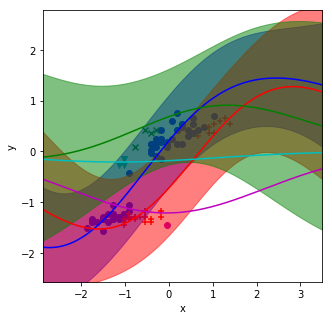

クラスタ数: 6
ARIの値: 0.06704875165669666
RMSEの値: [0.2210411112642816, 0.16722958221684328, 0.16101749230624415, 0.05529551057856254, 0.24250063545638967, 0.21242499645762902]
MAEの値: [0.4273200059307032, 0.3565570863018147, 0.3708184627029895, 0.23472579303852514, 0.49244353529759094, 0.4608958629209304]
r2scoreの値: [0.948111094055235, 0.9545752437451402, 0.5797099487161398, -0.0637300485153891, 0.0, 0.0]
実行時間: 9.073994398117065



  0%|          | 0/1 [00:00<?, ?it/s]

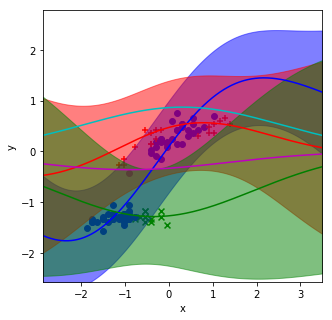

クラスタ数: 6
ARIの値: 0.052116971033834225
RMSEの値: [0.23867321877102812, 0.21913825494951805, 0.09410986993126476, 0.17451452713146087, 0.07190352348863266, 0.21242499645762902]
MAEの値: [0.4475731300755832, 0.4316260024551037, 0.27548101124297586, 0.4177493592232798, 0.26814832367298636, 0.4608958629209304]
r2scoreの値: [0.948410569087677, 0.450379937427386, -0.08648909921332137, 0.0, 0.0, 0.0]
実行時間: 9.406891345977783



  0%|          | 0/1 [00:00<?, ?it/s]

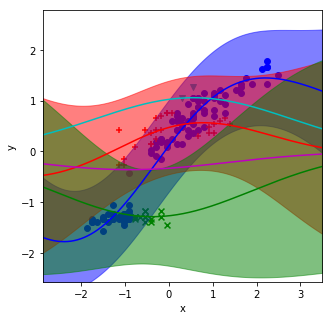

クラスタ数: 5
ARIの値: 0.057965440766004336
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.200732707977295



  0%|          | 0/1 [00:00<?, ?it/s]

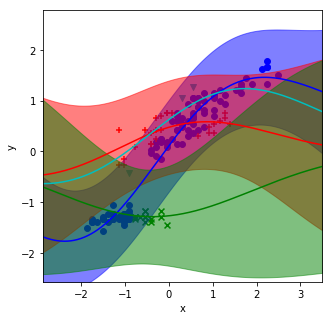

クラスタ数: 4
ARIの値: 0.05567127393643492
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.35561506827500944]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.585521844368421]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, 0.7789151844388543]
実行時間: 9.239670991897583



  0%|          | 0/1 [00:00<?, ?it/s]

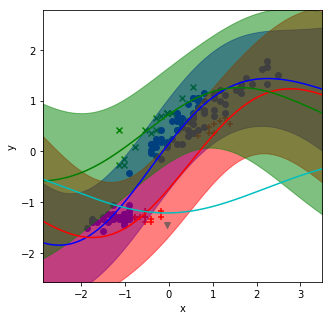

クラスタ数: 4
ARIの値: 0.018692543063984206
RMSEの値: [0.24845602125415328, 0.18001269287343719, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.4549902144310167, 0.38465643095013985, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9410333428037546, 0.956279273817081, 0.8129628024260871, 0.0]
実行時間: 9.56045913696289



  0%|          | 0/1 [00:00<?, ?it/s]

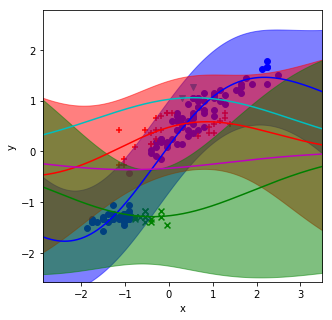

クラスタ数: 5
ARIの値: 0.05590743609650312
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.259337663650513



  0%|          | 0/1 [00:00<?, ?it/s]

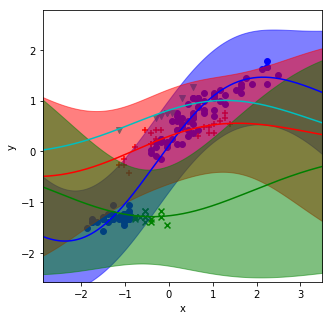

クラスタ数: 4
ARIの値: 0.08460333083420091
RMSEの値: [0.22563068856814633, 0.16440482025230702, 0.08700294713982068, 0.1306313729838254]
MAEの値: [0.4352080887481937, 0.3574625014036282, 0.25751029658961355, 0.30019624271148737]
r2scoreの値: [0.9539733844909962, 0.7185925759116996, -0.07952879140110203, 0.6706903409252489]
実行時間: 9.108047485351562



  0%|          | 0/1 [00:00<?, ?it/s]

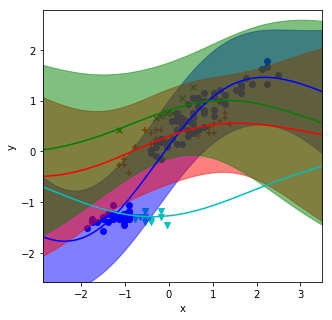

クラスタ数: 4
ARIの値: 0.0776358539060097
RMSEの値: [0.2289204841480767, 0.16812062277406575, 0.1306313729838254, 0.08700294713982068]
MAEの値: [0.4386322972764925, 0.36482004246174804, 0.30019624271148737, 0.25751029658961355]
r2scoreの値: [0.9522464637237278, 0.7136252851541016, 0.6706903409252489, -0.07952879140110203]
実行時間: 9.225522756576538



  0%|          | 0/1 [00:00<?, ?it/s]

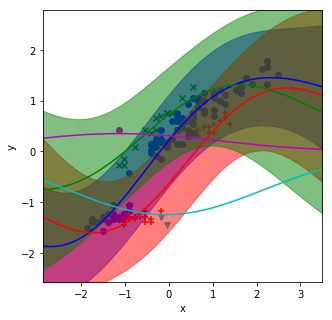

クラスタ数: 5
ARIの値: 0.055906492125080066
RMSEの値: [0.21137462009095087, 0.16911776794761868, 0.1264429865603285, 0.15065145270063807, 0.07026073648449821]
MAEの値: [0.41784609099752407, 0.35792306724856554, 0.3337347358806185, 0.35298973271963796, 0.26506741875322626]
r2scoreの値: [0.953721029383775, 0.9609563464939183, 0.9206316997175471, -2.1193441315438077, 0.0]
実行時間: 9.036547899246216



  0%|          | 0/1 [00:00<?, ?it/s]

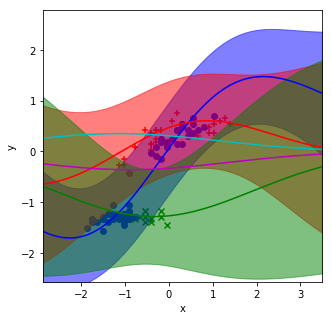

クラスタ数: 6
ARIの値: 0.07835922739630857
RMSEの値: [0.22314001156975094, 0.20399822856585773, 0.09410986993126476, 0.07026073648449821, 0.07190352348863266, 0.15298800258011977]
MAEの値: [0.4336695849322308, 0.42158488561770296, 0.27548101124297586, 0.26506741875322626, 0.26814832367298636, 0.33240995395576106]
r2scoreの値: [0.956449334684605, 0.5470182360060705, -0.08648909921332137, 0.0, 0.0, -0.8094805431611596]
実行時間: 9.151145696640015



  0%|          | 0/1 [00:00<?, ?it/s]

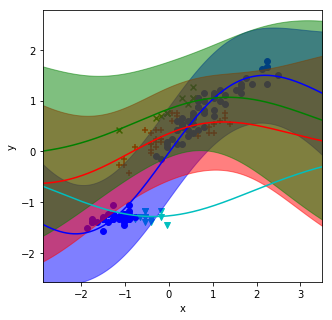

クラスタ数: 4
ARIの値: 0.14839412611232383
RMSEの値: [0.1944065615574743, 0.18315552383021758, 0.10970520764484326, 0.09410986993126476]
MAEの値: [0.40852357087757873, 0.38494383126413095, 0.28753211184417105, 0.27548101124297586]
r2scoreの値: [0.9687965079941392, 0.6456703212636077, 0.7681058502937851, -0.08648909921332137]
実行時間: 6.772665739059448



  0%|          | 0/1 [00:00<?, ?it/s]

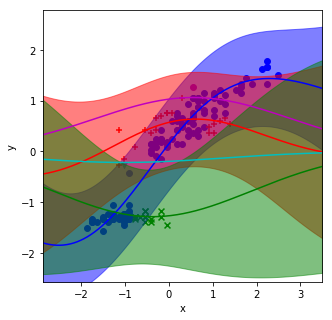

クラスタ数: 5
ARIの値: 0.03263576972497164
RMSEの値: [0.2521236064585579, 0.21720665485634247, 0.08700294713982068, 0.04347067149400652, 0.21242499645762902]
MAEの値: [0.45822214307448117, 0.4251486550084224, 0.25751029658961355, 0.2084962145795614, 0.4608958629209304]
r2scoreの値: [0.938769642163683, 0.4835412053974316, -0.07952879140110203, 0.0, 0.0]
実行時間: 9.972625970840454



  0%|          | 0/1 [00:00<?, ?it/s]

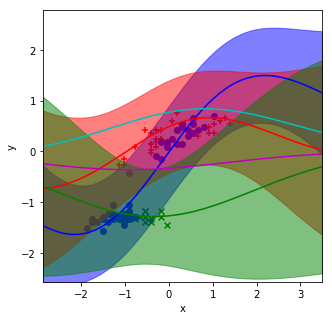

クラスタ数: 6
ARIの値: 0.10335060196117916
RMSEの値: [0.19825420908789315, 0.2253432617496811, 0.09410986993126476, 0.17604786737407943, 0.07190352348863266, 0.21242499645762902]
MAEの値: [0.41218738341393263, 0.4444451061021872, 0.27548101124297586, 0.40019922558072274, 0.26814832367298636, 0.4608958629209304]
r2scoreの値: [0.9672223695460381, 0.5478388670506875, -0.08648909921332137, 0.6831634192165038, 0.0, 0.0]
実行時間: 8.959873676300049



  0%|          | 0/1 [00:00<?, ?it/s]

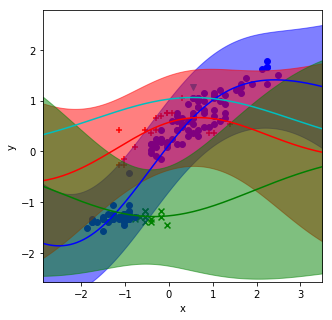

クラスタ数: 4
ARIの値: 0.019846970217546545
RMSEの値: [0.2719744229861532, 0.2448851447404549, 0.09410986993126476, 0.21242499645762902]
MAEの値: [0.47716007524374043, 0.46544735766828976, 0.27548101124297586, 0.4608958629209304]
r2scoreの値: [0.9278217048025297, 0.5467646290891927, -0.08648909921332137, 0.0]
実行時間: 10.107603311538696



  0%|          | 0/1 [00:00<?, ?it/s]

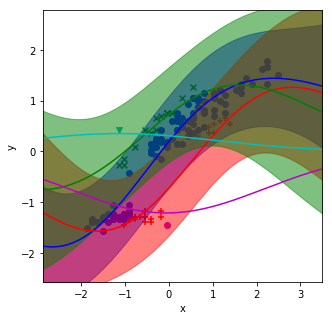

クラスタ数: 5
ARIの値: 0.046798515989786814
RMSEの値: [0.22901682294107167, 0.1704177570206331, 0.1264429865603285, 0.07026073648449821, 0.24250063545638967]
MAEの値: [0.4361218486813688, 0.3613761589876043, 0.3337347358806185, 0.26506741875322626, 0.49244353529759094]
r2scoreの値: [0.9463206648658692, 0.9557479097488686, 0.9206316997175471, 0.0, 0.0]
実行時間: 9.309698104858398



  0%|          | 0/1 [00:00<?, ?it/s]

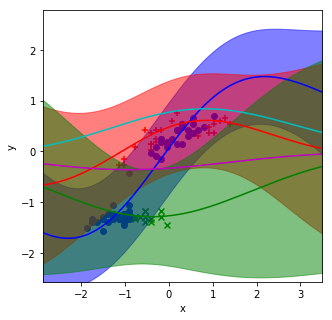

クラスタ数: 6
ARIの値: 0.08047201547151159
RMSEの値: [0.21465141671869986, 0.20196943074045887, 0.08700294713982068, 0.17604786737407943, 0.07190352348863266, 0.21242499645762902]
MAEの値: [0.4267093646723748, 0.4203622834623861, 0.25751029658961355, 0.40019922558072274, 0.26814832367298636, 0.4608958629209304]
r2scoreの値: [0.9595440702841476, 0.5553643738343178, -0.07952879140110203, 0.6831634192165038, 0.0, 0.0]
実行時間: 8.972368001937866



  0%|          | 0/1 [00:00<?, ?it/s]

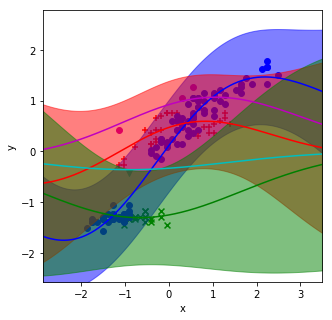

クラスタ数: 5
ARIの値: 0.08744654635065592
RMSEの値: [0.2126256731518151, 0.2013267452021103, 0.09067085013469516, 0.07190352348863266, 0.15745708238245862]
MAEの値: [0.42324118513321324, 0.41826551779157556, 0.26552899739278646, 0.26814832367298636, 0.3699396756481691]
r2scoreの値: [0.9586698284380534, 0.5441755890839617, -0.1303658321477814, 0.0, 0.8093848133820433]
実行時間: 8.96511459350586



  0%|          | 0/1 [00:00<?, ?it/s]

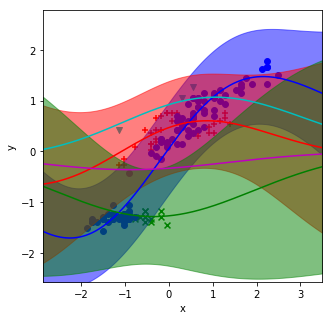

クラスタ数: 5
ARIの値: 0.07882235493570094
RMSEの値: [0.22314001156975094, 0.20399822856585773, 0.09410986993126476, 0.15745708238245862, 0.07190352348863266]
MAEの値: [0.4336695849322308, 0.42158488561770296, 0.27548101124297586, 0.3699396756481691, 0.26814832367298636]
r2scoreの値: [0.956449334684605, 0.5470182360060705, -0.08648909921332137, 0.8093848133820433, 0.0]
実行時間: 9.113601446151733



  0%|          | 0/1 [00:00<?, ?it/s]

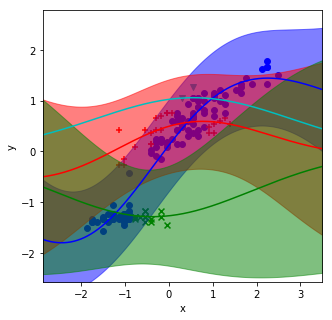

クラスタ数: 4
ARIの値: 0.045949491335736725
RMSEの値: [0.24326835926520424, 0.21686640102782406, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4515671698048527, 0.4269768837592038, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9444403138409554, 0.4965540332458964, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.53870415687561



  0%|          | 0/1 [00:00<?, ?it/s]

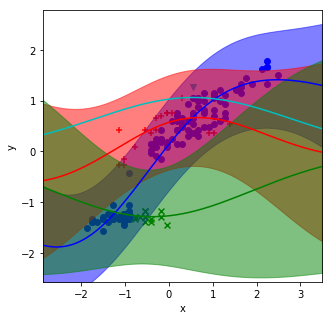

クラスタ数: 4
ARIの値: 0.027007907472092092
RMSEの値: [0.26538076829777935, 0.2448851447404549, 0.08700294713982068, 0.21242499645762902]
MAEの値: [0.4712727165508744, 0.46544735766828976, 0.25751029658961355, 0.4608958629209304]
r2scoreの値: [0.930349635589732, 0.5467646290891927, -0.07952879140110203, 0.0]
実行時間: 9.840478420257568



  0%|          | 0/1 [00:00<?, ?it/s]

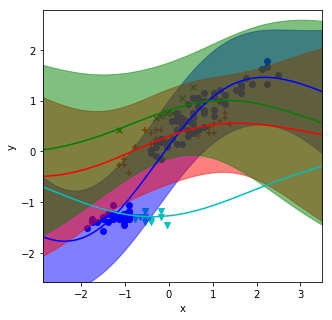

クラスタ数: 4
ARIの値: 0.0776358539060097
RMSEの値: [0.2289204841480767, 0.16812062277406575, 0.1306313729838254, 0.08700294713982068]
MAEの値: [0.4386322972764925, 0.36482004246174804, 0.30019624271148737, 0.25751029658961355]
r2scoreの値: [0.9522464637237278, 0.7136252851541016, 0.6706903409252489, -0.07952879140110203]
実行時間: 9.074630975723267



  0%|          | 0/1 [00:00<?, ?it/s]

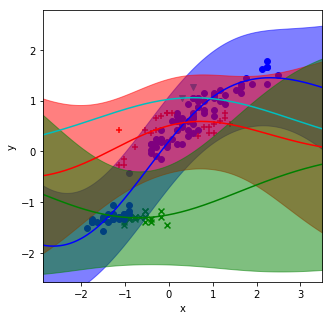

クラスタ数: 4
ARIの値: 0.07743286743661607
RMSEの値: [0.22281803532791178, 0.22007911846765854, 0.08437963583850182, 0.15298800258011977]
MAEの値: [0.43014565761223716, 0.43275551088418496, 0.25406410223949993, 0.33240995395576106]
r2scoreの値: [0.9499166574395718, 0.47518779846861925, -0.1212311399078907, -0.8094805431611596]
実行時間: 9.04406476020813



  0%|          | 0/1 [00:00<?, ?it/s]

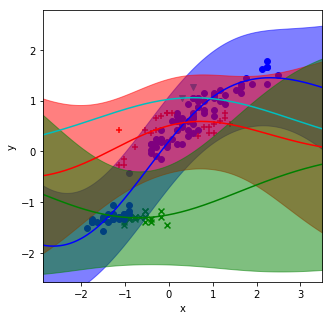

クラスタ数: 4
ARIの値: 0.07743286743661607
RMSEの値: [0.22281803532791178, 0.22007911846765854, 0.08437963583850182, 0.15298800258011977]
MAEの値: [0.43014565761223716, 0.43275551088418496, 0.25406410223949993, 0.33240995395576106]
r2scoreの値: [0.9499166574395718, 0.47518779846861925, -0.1212311399078907, -0.8094805431611596]
実行時間: 9.211313724517822



  0%|          | 0/1 [00:00<?, ?it/s]

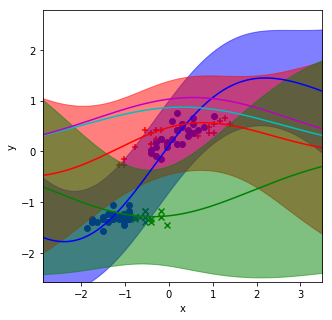

クラスタ数: 6
ARIの値: 0.057735789243040875
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.17451452713146087, 0.21242499645762902, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.4177493592232798, 0.4608958629209304, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, 0.0, 0.0, 0.0]
実行時間: 9.382357120513916



  0%|          | 0/1 [00:00<?, ?it/s]

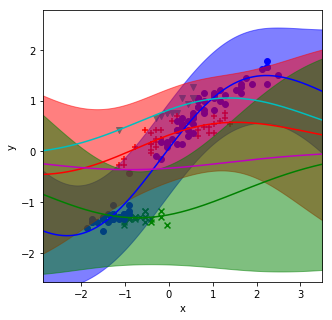

クラスタ数: 5
ARIの値: 0.19351265574182597
RMSEの値: [0.16807417098594263, 0.15164950873093663, 0.08437963583850182, 0.11138221311374977, 0.07190352348863266]
MAEの値: [0.381147899035658, 0.35178774928155143, 0.25406410223949993, 0.2850216333500082, 0.26814832367298636]
r2scoreの値: [0.9757317599594549, 0.6842327841796383, -0.1212311399078907, 0.7245700953187266, 0.0]
実行時間: 6.5425331592559814



  0%|          | 0/1 [00:00<?, ?it/s]

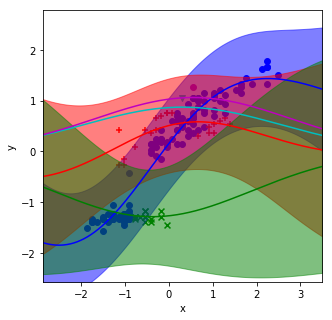

クラスタ数: 5
ARIの値: 0.03785642209592825
RMSEの値: [0.24845602125415328, 0.22223460782702356, 0.08700294713982068, 0.17451452713146087, 0.21242499645762902]
MAEの値: [0.4549902144310167, 0.43510246691843424, 0.25751029658961355, 0.4177493592232798, 0.4608958629209304]
r2scoreの値: [0.9410333428037546, 0.483069846349094, -0.07952879140110203, 0.0, 0.0]
実行時間: 9.537119388580322



  0%|          | 0/1 [00:00<?, ?it/s]

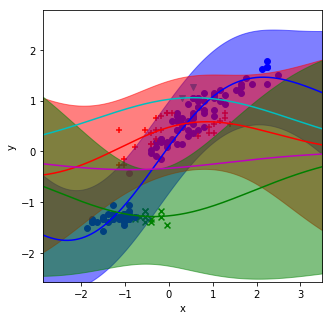

クラスタ数: 5
ARIの値: 0.050515823250201784
RMSEの値: [0.23525719264051043, 0.21952068092857152, 0.09410986993126476, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.4440479575166554, 0.4332025092202128, 0.27548101124297586, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9501131208248446, 0.4586018558906977, -0.08648909921332137, -0.8094805431611596, 0.0]
実行時間: 9.421363830566406



  0%|          | 0/1 [00:00<?, ?it/s]

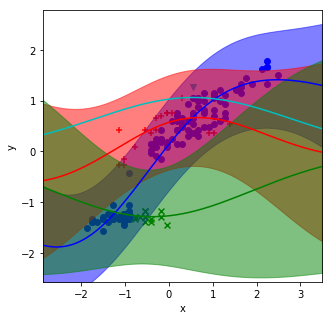

クラスタ数: 4
ARIの値: 0.027007907472092092
RMSEの値: [0.26538076829777935, 0.2448851447404549, 0.08700294713982068, 0.21242499645762902]
MAEの値: [0.4712727165508744, 0.46544735766828976, 0.25751029658961355, 0.4608958629209304]
r2scoreの値: [0.930349635589732, 0.5467646290891927, -0.07952879140110203, 0.0]
実行時間: 9.867006540298462



  0%|          | 0/1 [00:00<?, ?it/s]

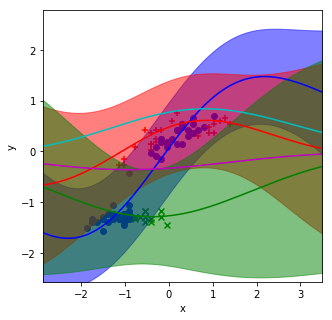

クラスタ数: 6
ARIの値: 0.08047201547151159
RMSEの値: [0.21465141671869986, 0.20196943074045887, 0.08700294713982068, 0.17604786737407943, 0.07190352348863266, 0.21242499645762902]
MAEの値: [0.4267093646723748, 0.4203622834623861, 0.25751029658961355, 0.40019922558072274, 0.26814832367298636, 0.4608958629209304]
r2scoreの値: [0.9595440702841476, 0.5553643738343178, -0.07952879140110203, 0.6831634192165038, 0.0, 0.0]
実行時間: 8.984644651412964



  0%|          | 0/1 [00:00<?, ?it/s]

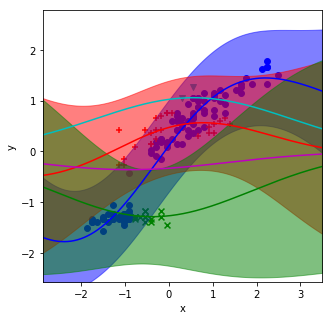

クラスタ数: 5
ARIの値: 0.057965440766004336
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.37892484664917



  0%|          | 0/1 [00:00<?, ?it/s]

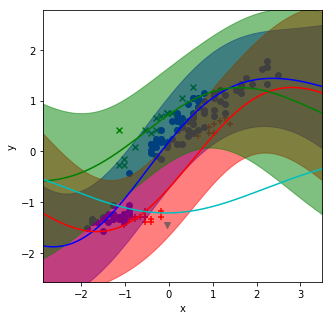

クラスタ数: 4
ARIの値: 0.04215517453013817
RMSEの値: [0.23195992639813776, 0.17303381529242565, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.43907340596201017, 0.3656448066917663, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9456680019593142, 0.9550860046425017, 0.8129628024260871, 0.0]
実行時間: 9.28795337677002



  0%|          | 0/1 [00:00<?, ?it/s]

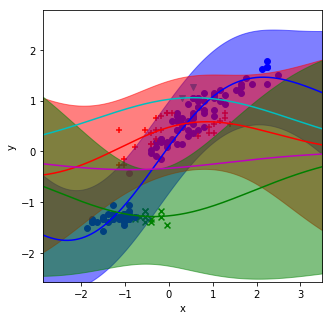

クラスタ数: 5
ARIの値: 0.050515823250201784
RMSEの値: [0.23525719264051043, 0.21952068092857152, 0.09410986993126476, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.4440479575166554, 0.4332025092202128, 0.27548101124297586, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9501131208248446, 0.4586018558906977, -0.08648909921332137, -0.8094805431611596, 0.0]
実行時間: 9.270077466964722



  0%|          | 0/1 [00:00<?, ?it/s]

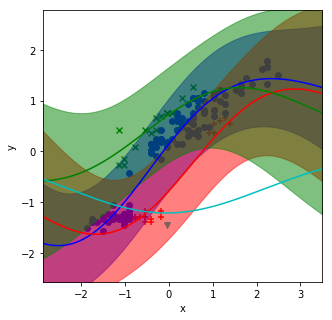

クラスタ数: 4
ARIの値: 0.017433918467359675
RMSEの値: [0.2555956748933826, 0.1669182921599666, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.4615425159004519, 0.3757542888208655, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9366081464049067, 0.9602364352821705, 0.8129628024260871, 0.0]
実行時間: 9.754186391830444



  0%|          | 0/1 [00:00<?, ?it/s]

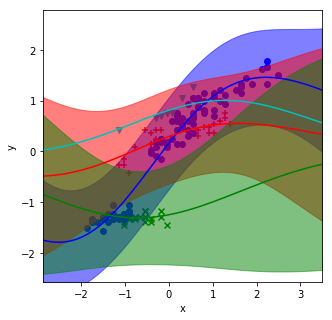

クラスタ数: 4
ARIの値: 0.12711973151712566
RMSEの値: [0.2052379965028639, 0.16146674519576562, 0.08437963583850182, 0.1306313729838254]
MAEの値: [0.4138724440912516, 0.3525190045939177, 0.25406410223949993, 0.30019624271148737]
r2scoreの値: [0.9597874399659194, 0.718703374930469, -0.1212311399078907, 0.6706903409252489]
実行時間: 8.791978359222412



  0%|          | 0/1 [00:00<?, ?it/s]

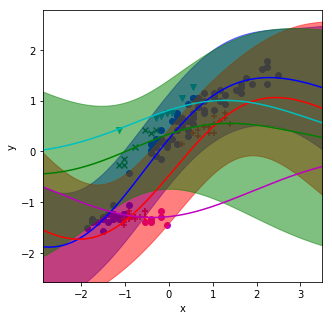

クラスタ数: 5
ARIの値: 0.06881844193732024
RMSEの値: [0.19636923092247288, 0.14456350445479924, 0.1862470181033441, 0.1306313729838254, 0.10364818368367507]
MAEの値: [0.40359004296252626, 0.3382411773217902, 0.41090189133244526, 0.30019624271148737, 0.3003325115133673]
r2scoreの値: [0.9602684719888281, 0.972990639400443, 0.5938002796105628, 0.6706903409252489, -0.2458157574275308]
実行時間: 6.67064642906189



  0%|          | 0/1 [00:00<?, ?it/s]

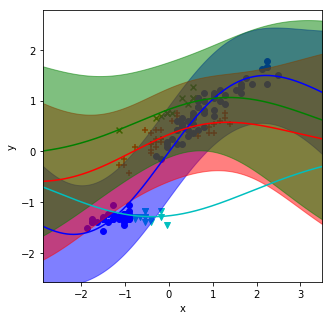

クラスタ数: 4
ARIの値: 0.15791341421361169
RMSEの値: [0.18943463507216218, 0.17425402445919533, 0.10901392972095483, 0.08700294713982068]
MAEの値: [0.4046676210574225, 0.37246351118512927, 0.28429511761304915, 0.25751029658961355]
r2scoreの値: [0.9701693042160308, 0.664518796347344, 0.7536279905664361, -0.07952879140110203]
実行時間: 6.600572824478149



  0%|          | 0/1 [00:00<?, ?it/s]

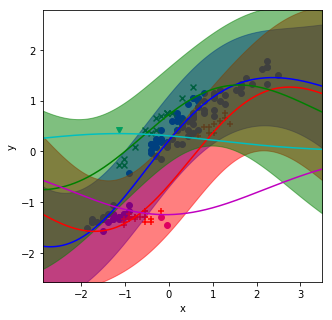

クラスタ数: 5
ARIの値: 0.056381940156031984
RMSEの値: [0.21456557471074908, 0.16000387539445185, 0.1264429865603285, 0.07026073648449821, 0.15065145270063807]
MAEの値: [0.4211561536494559, 0.34991946796185086, 0.3337347358806185, 0.26506741875322626, 0.35298973271963796]
r2scoreの値: [0.9518597221584335, 0.9641750855776827, 0.9206316997175471, 0.0, -2.1193441315438077]
実行時間: 9.42210054397583



  0%|          | 0/1 [00:00<?, ?it/s]

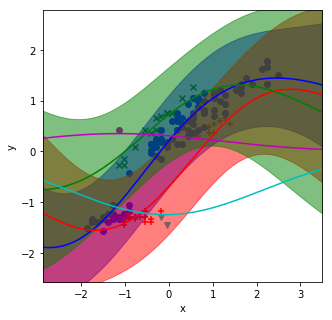

クラスタ数: 5
ARIの値: 0.06300045233909439
RMSEの値: [0.2210411112642816, 0.15541140235012077, 0.1264429865603285, 0.15065145270063807, 0.07026073648449821]
MAEの値: [0.4273200059307032, 0.34448394020476897, 0.3337347358806185, 0.35298973271963796, 0.26506741875322626]
r2scoreの値: [0.948111094055235, 0.9616316320600766, 0.9206316997175471, -2.1193441315438077, 0.0]
実行時間: 9.825070858001709



  0%|          | 0/1 [00:00<?, ?it/s]

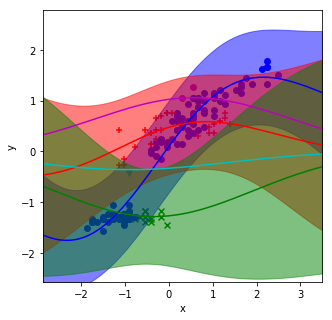

クラスタ数: 5
ARIの値: 0.050515823250201784
RMSEの値: [0.23525719264051043, 0.21952068092857152, 0.09410986993126476, 0.07190352348863266, 0.15298800258011977]
MAEの値: [0.4440479575166554, 0.4332025092202128, 0.27548101124297586, 0.26814832367298636, 0.33240995395576106]
r2scoreの値: [0.9501131208248446, 0.4586018558906977, -0.08648909921332137, 0.0, -0.8094805431611596]
実行時間: 9.714601278305054



  0%|          | 0/1 [00:00<?, ?it/s]

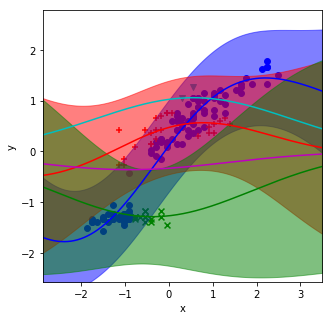

クラスタ数: 5
ARIの値: 0.057965440766004336
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.29149866104126



  0%|          | 0/1 [00:00<?, ?it/s]

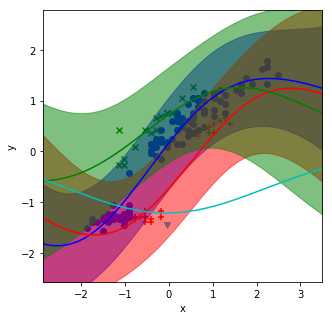

クラスタ数: 4
ARIの値: 0.024536220271154832
RMSEの値: [0.24296375452264843, 0.17777604261195665, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.4496033909664691, 0.3783481388624934, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9426673250617518, 0.9560348305726192, 0.8129628024260871, 0.0]
実行時間: 9.22570514678955



  0%|          | 0/1 [00:00<?, ?it/s]

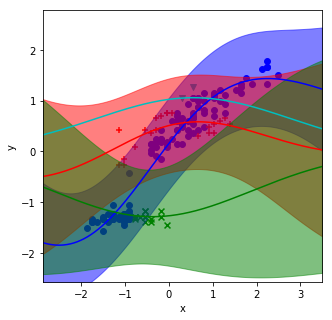

クラスタ数: 4
ARIの値: 0.03808122905940996
RMSEの値: [0.24845602125415328, 0.22223460782702356, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4549902144310167, 0.43510246691843424, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9410333428037546, 0.483069846349094, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.357506036758423



  0%|          | 0/1 [00:00<?, ?it/s]

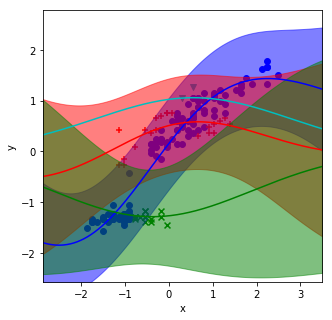

クラスタ数: 4
ARIの値: 0.03808122905940996
RMSEの値: [0.24845602125415328, 0.22223460782702356, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4549902144310167, 0.43510246691843424, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9410333428037546, 0.483069846349094, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.529145002365112



  0%|          | 0/1 [00:00<?, ?it/s]

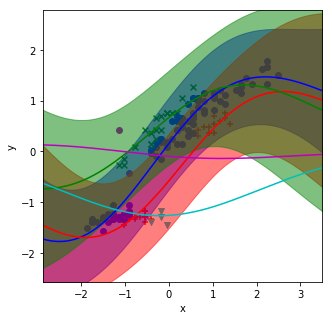

クラスタ数: 5
ARIの値: 0.05003703276376074
RMSEの値: [0.19934304558918722, 0.15169304254409866, 0.15254777034014852, 0.1278194929582779, 0.4143616590979295]
MAEの値: [0.40828358375012946, 0.3386567641067766, 0.3646572114126873, 0.3331137460977132, 0.6437091078921185]
r2scoreの値: [0.9625819464274645, 0.9718602490742938, 0.8622646636360699, -0.3701285368263558, 0.05607875748604507]
実行時間: 6.740795612335205



  0%|          | 0/1 [00:00<?, ?it/s]

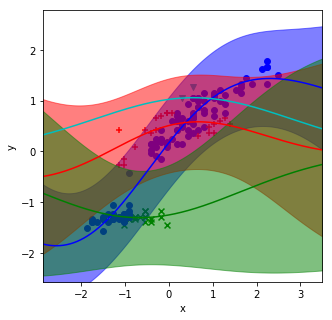

クラスタ数: 4
ARIの値: 0.051349695163116306
RMSEの値: [0.24017611091551308, 0.22223460782702356, 0.09067085013469516, 0.15298800258011977]
MAEの値: [0.4469649818675066, 0.43510246691843424, 0.26552899739278646, 0.33240995395576106]
r2scoreの値: [0.9432878485240055, 0.483069846349094, -0.1303658321477814, -0.8094805431611596]
実行時間: 9.250859498977661



  0%|          | 0/1 [00:00<?, ?it/s]

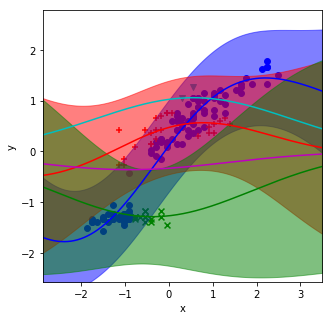

クラスタ数: 5
ARIの値: 0.057965440766004336
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.283050537109375



  0%|          | 0/1 [00:00<?, ?it/s]

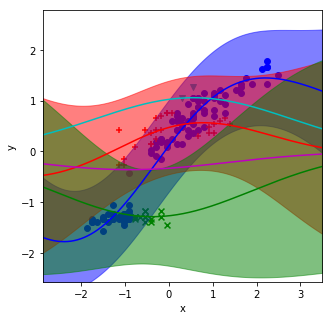

クラスタ数: 5
ARIの値: 0.057965440766004336
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.29110074043274



  0%|          | 0/1 [00:00<?, ?it/s]

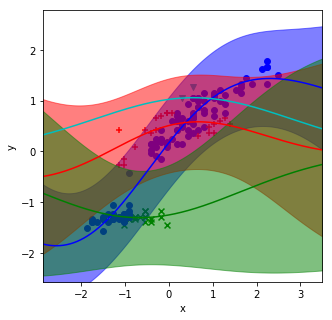

クラスタ数: 4
ARIの値: 0.051349695163116306
RMSEの値: [0.24017611091551308, 0.22223460782702356, 0.09067085013469516, 0.15298800258011977]
MAEの値: [0.4469649818675066, 0.43510246691843424, 0.26552899739278646, 0.33240995395576106]
r2scoreの値: [0.9432878485240055, 0.483069846349094, -0.1303658321477814, -0.8094805431611596]
実行時間: 9.123587131500244



  0%|          | 0/1 [00:00<?, ?it/s]

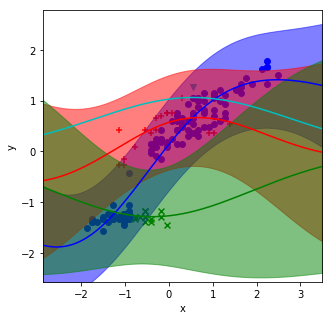

クラスタ数: 4
ARIの値: 0.027007907472092092
RMSEの値: [0.26538076829777935, 0.2448851447404549, 0.08700294713982068, 0.21242499645762902]
MAEの値: [0.4712727165508744, 0.46544735766828976, 0.25751029658961355, 0.4608958629209304]
r2scoreの値: [0.930349635589732, 0.5467646290891927, -0.07952879140110203, 0.0]
実行時間: 9.635738849639893



  0%|          | 0/1 [00:00<?, ?it/s]

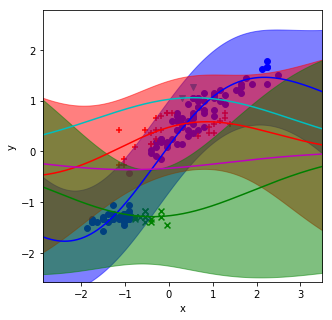

クラスタ数: 5
ARIの値: 0.05590743609650312
RMSEの値: [0.2289204841480767, 0.21952068092857152, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.4386322972764925, 0.4332025092202128, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9522464637237278, 0.4586018558906977, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 9.13552713394165



  0%|          | 0/1 [00:00<?, ?it/s]

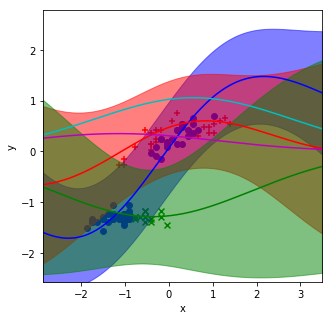

クラスタ数: 6
ARIの値: 0.08824199139049631
RMSEの値: [0.2112461609205817, 0.20058021259188852, 0.08700294713982068, 0.15298800258011977, 0.07026073648449821, 0.07190352348863266]
MAEの値: [0.42316645462214497, 0.41890130815294446, 0.25751029658961355, 0.33240995395576106, 0.26506741875322626, 0.26814832367298636]
r2scoreの値: [0.9611367184521352, 0.5479483377719253, -0.07952879140110203, -0.8094805431611596, 0.0, 0.0]
実行時間: 9.223161697387695



  0%|          | 0/1 [00:00<?, ?it/s]

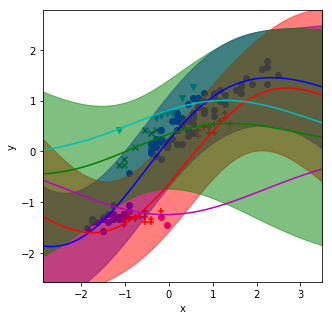

クラスタ数: 5
ARIの値: 0.06466536220604172
RMSEの値: [0.21137462009095087, 0.16911776794761868, 0.1862470181033441, 0.1306313729838254, 0.15065145270063807]
MAEの値: [0.41784609099752407, 0.35792306724856554, 0.41090189133244526, 0.30019624271148737, 0.35298973271963796]
r2scoreの値: [0.953721029383775, 0.9609563464939183, 0.5938002796105628, 0.6706903409252489, -2.1193441315438077]
実行時間: 8.777430295944214



  0%|          | 0/1 [00:00<?, ?it/s]

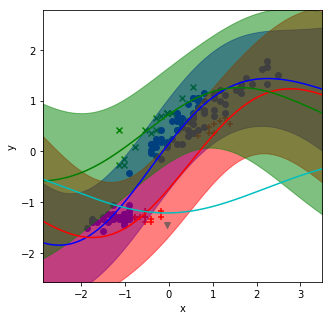

クラスタ数: 4
ARIの値: 0.018692543063984206
RMSEの値: [0.24845602125415328, 0.18001269287343719, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.4549902144310167, 0.38465643095013985, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9410333428037546, 0.956279273817081, 0.8129628024260871, 0.0]
実行時間: 9.36304235458374



  0%|          | 0/1 [00:00<?, ?it/s]

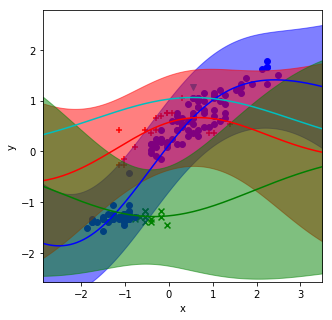

クラスタ数: 4
ARIの値: 0.019846970217546545
RMSEの値: [0.2719744229861532, 0.2448851447404549, 0.09410986993126476, 0.21242499645762902]
MAEの値: [0.47716007524374043, 0.46544735766828976, 0.27548101124297586, 0.4608958629209304]
r2scoreの値: [0.9278217048025297, 0.5467646290891927, -0.08648909921332137, 0.0]
実行時間: 9.719096660614014



  0%|          | 0/1 [00:00<?, ?it/s]

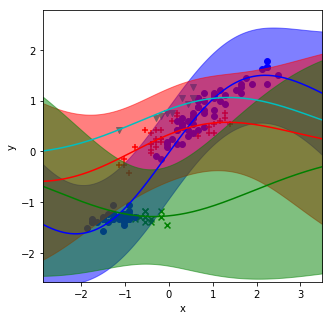

クラスタ数: 4
ARIの値: 0.15434316656675814
RMSEの値: [0.1944065615574743, 0.17425402445919533, 0.09410986993126476, 0.10901392972095483]
MAEの値: [0.40852357087757873, 0.37246351118512927, 0.27548101124297586, 0.28429511761304915]
r2scoreの値: [0.9687965079941392, 0.664518796347344, -0.08648909921332137, 0.7536279905664361]
実行時間: 6.5310118198394775



  0%|          | 0/1 [00:00<?, ?it/s]

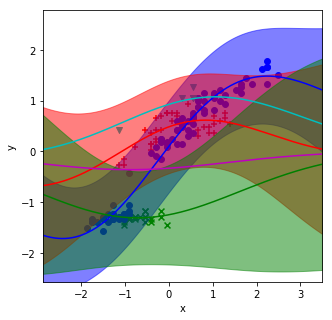

クラスタ数: 5
ARIの値: 0.1303546294596414
RMSEの値: [0.18125813117847037, 0.20276684609165618, 0.08437963583850182, 0.11923982072864704, 0.07190352348863266]
MAEの値: [0.39271016322305785, 0.42189328052678154, 0.25406410223949993, 0.2875505249357873, 0.26814832367298636]
r2scoreの値: [0.970451775482526, 0.5475529012852283, -0.1212311399078907, 0.8271677905830277, 0.0]
実行時間: 6.542797803878784



  0%|          | 0/1 [00:00<?, ?it/s]

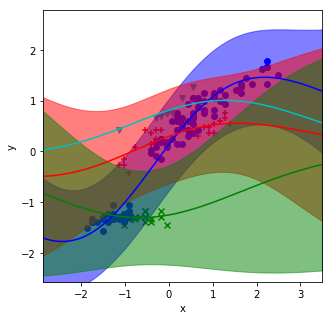

クラスタ数: 4
ARIの値: 0.09666971181795529
RMSEの値: [0.2182289674139932, 0.16440482025230702, 0.09067085013469516, 0.1306313729838254]
MAEの値: [0.4276098443826241, 0.3574625014036282, 0.26552899739278646, 0.30019624271148737]
r2scoreの値: [0.9557833494204818, 0.7185925759116996, -0.1303658321477814, 0.6706903409252489]
実行時間: 8.680104494094849



  0%|          | 0/1 [00:00<?, ?it/s]

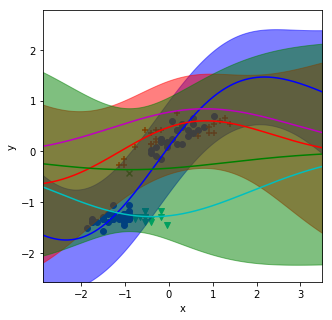

クラスタ数: 6
ARIの値: 0.06881725012755997
RMSEの値: [0.22317996070527346, 0.20306340604489226, 0.07190352348863266, 0.08700294713982068, 0.17604786737407943, 0.21242499645762902]
MAEの値: [0.43412064347332235, 0.4202238937690791, 0.26814832367298636, 0.25751029658961355, 0.40019922558072274, 0.4608958629209304]
r2scoreの値: [0.9552615770331758, 0.5515138831942499, 0.0, -0.07952879140110203, 0.6831634192165038, 0.0]
実行時間: 8.937674760818481



  0%|          | 0/1 [00:00<?, ?it/s]

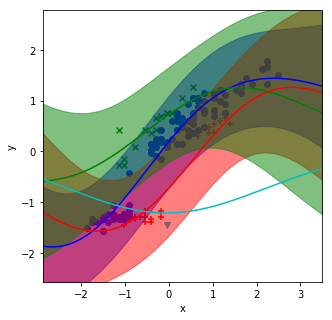

クラスタ数: 4
ARIの値: 0.047829952562327284
RMSEの値: [0.22901682294107167, 0.1704177570206331, 0.1880764158705766, 0.24250063545638967]
MAEの値: [0.4361218486813688, 0.3613761589876043, 0.38949614584902603, 0.49244353529759094]
r2scoreの値: [0.9463206648658692, 0.9557479097488686, 0.8129628024260871, 0.0]
実行時間: 8.993820190429688



  0%|          | 0/1 [00:00<?, ?it/s]

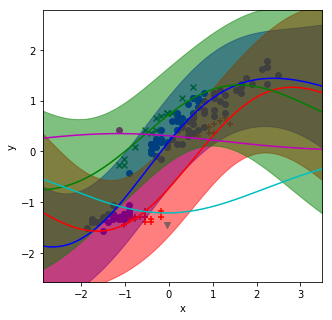

クラスタ数: 5
ARIの値: 0.046798515989786814
RMSEの値: [0.22901682294107167, 0.1704177570206331, 0.1264429865603285, 0.24250063545638967, 0.07026073648449821]
MAEの値: [0.4361218486813688, 0.3613761589876043, 0.3337347358806185, 0.49244353529759094, 0.26506741875322626]
r2scoreの値: [0.9463206648658692, 0.9557479097488686, 0.9206316997175471, 0.0, 0.0]
実行時間: 8.876746892929077



  0%|          | 0/1 [00:00<?, ?it/s]

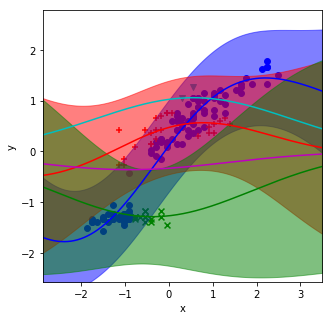

クラスタ数: 5
ARIの値: 0.057965440766004336
RMSEの値: [0.23240611571914116, 0.21913825494951805, 0.08700294713982068, 0.15298800258011977, 0.07190352348863266]
MAEの値: [0.44219702187050525, 0.4316260024551037, 0.25751029658961355, 0.33240995395576106, 0.26814832367298636]
r2scoreの値: [0.9505309895449507, 0.450379937427386, -0.07952879140110203, -0.8094805431611596, 0.0]
実行時間: 8.972306489944458



  0%|          | 0/1 [00:00<?, ?it/s]

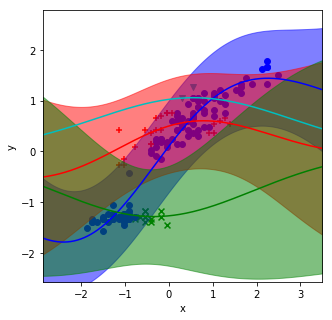

クラスタ数: 4
ARIの値: 0.03554159998105177
RMSEの値: [0.25332858628892896, 0.2197235036128093, 0.09410986993126476, 0.15298800258011977]
MAEの値: [0.460755876253854, 0.4304587795058361, 0.27548101124297586, 0.33240995395576106]
r2scoreの値: [0.9400149301419216, 0.5034059680828378, -0.08648909921332137, -0.8094805431611596]
実行時間: 9.266820669174194



  0%|          | 0/1 [00:00<?, ?it/s]

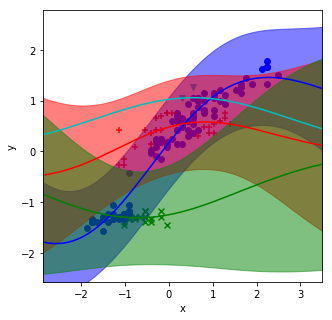

クラスタ数: 4
ARIの値: 0.0893003027681139
RMSEの値: [0.2147211359339366, 0.21860158816364378, 0.08437963583850182, 0.15298800258011977]
MAEの値: [0.42285232195529404, 0.4310007568196545, 0.25406410223949993, 0.33240995395576106]
r2scoreの値: [0.9548103409538385, 0.4583752135666065, -0.1212311399078907, -0.8094805431611596]
実行時間: 8.608918190002441



  0%|          | 0/1 [00:00<?, ?it/s]

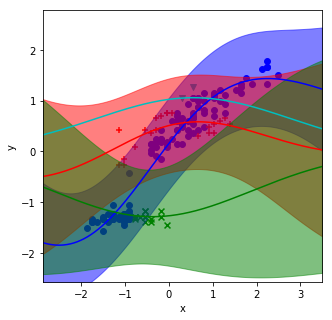

クラスタ数: 4
ARIの値: 0.03808122905940996
RMSEの値: [0.24845602125415328, 0.22223460782702356, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4549902144310167, 0.43510246691843424, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9410333428037546, 0.483069846349094, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.568089962005615



  0%|          | 0/1 [00:00<?, ?it/s]

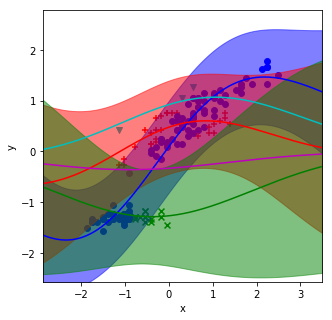

クラスタ数: 5
ARIの値: 0.06928242442320875
RMSEの値: [0.22317996070527346, 0.20306340604489226, 0.08700294713982068, 0.15745708238245862, 0.07190352348863266]
MAEの値: [0.43412064347332235, 0.4202238937690791, 0.25751029658961355, 0.3699396756481691, 0.26814832367298636]
r2scoreの値: [0.9552615770331758, 0.5515138831942499, -0.07952879140110203, 0.8093848133820433, 0.0]
実行時間: 8.961780309677124



  0%|          | 0/1 [00:00<?, ?it/s]

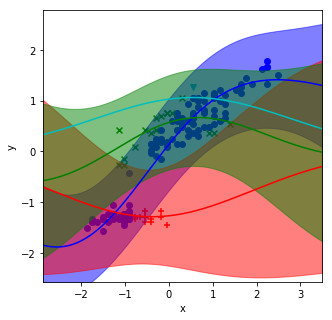

クラスタ数: 4
ARIの値: 0.027007907472092092
RMSEの値: [0.26538076829777935, 0.08700294713982068, 0.2448851447404549, 0.21242499645762902]
MAEの値: [0.4712727165508744, 0.25751029658961355, 0.46544735766828976, 0.4608958629209304]
r2scoreの値: [0.930349635589732, -0.07952879140110203, 0.5467646290891927, 0.0]
実行時間: 9.628756523132324



  0%|          | 0/1 [00:00<?, ?it/s]

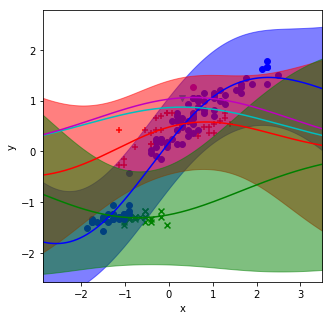

クラスタ数: 5
ARIの値: 0.08906443842652263
RMSEの値: [0.2147211359339366, 0.21860158816364378, 0.08437963583850182, 0.17451452713146087, 0.21242499645762902]
MAEの値: [0.42285232195529404, 0.4310007568196545, 0.25406410223949993, 0.4177493592232798, 0.4608958629209304]
r2scoreの値: [0.9548103409538385, 0.4583752135666065, -0.1212311399078907, 0.0, 0.0]
実行時間: 8.7861909866333



  0%|          | 0/1 [00:00<?, ?it/s]

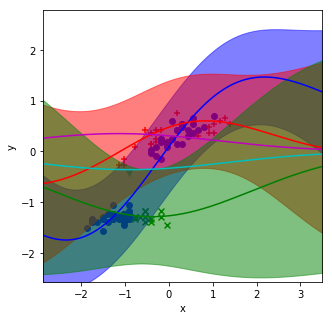

クラスタ数: 6
ARIの値: 0.06881725012755997
RMSEの値: [0.22317996070527346, 0.20306340604489226, 0.08700294713982068, 0.07190352348863266, 0.07026073648449821, 0.15298800258011977]
MAEの値: [0.43412064347332235, 0.4202238937690791, 0.25751029658961355, 0.26814832367298636, 0.26506741875322626, 0.33240995395576106]
r2scoreの値: [0.9552615770331758, 0.5515138831942499, -0.07952879140110203, 0.0, 0.0, -0.8094805431611596]
実行時間: 8.845170259475708



  0%|          | 0/1 [00:00<?, ?it/s]

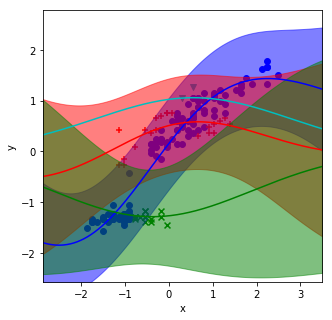

クラスタ数: 4
ARIの値: 0.03808122905940996
RMSEの値: [0.24845602125415328, 0.22223460782702356, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4549902144310167, 0.43510246691843424, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9410333428037546, 0.483069846349094, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.416278839111328



  0%|          | 0/1 [00:00<?, ?it/s]

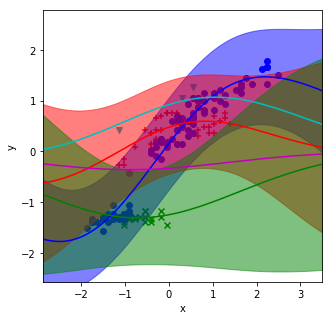

クラスタ数: 5
ARIの値: 0.1166962335062808
RMSEの値: [0.19934304558918722, 0.1989487836550778, 0.08437963583850182, 0.15745708238245862, 0.07190352348863266]
MAEの値: [0.40828358375012946, 0.41570541013272094, 0.25406410223949993, 0.3699396756481691, 0.26814832367298636]
r2scoreの値: [0.9625819464274645, 0.5445107263181633, -0.1212311399078907, 0.8093848133820433, 0.0]
実行時間: 6.7444658279418945



  0%|          | 0/1 [00:00<?, ?it/s]

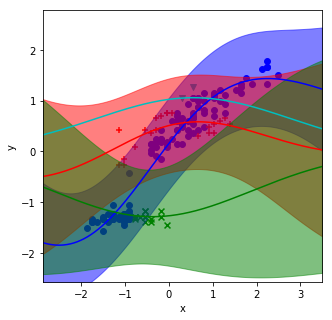

クラスタ数: 4
ARIの値: 0.03808122905940996
RMSEの値: [0.24845602125415328, 0.22223460782702356, 0.08700294713982068, 0.15298800258011977]
MAEの値: [0.4549902144310167, 0.43510246691843424, 0.25751029658961355, 0.33240995395576106]
r2scoreの値: [0.9410333428037546, 0.483069846349094, -0.07952879140110203, -0.8094805431611596]
実行時間: 9.332453489303589



  0%|          | 0/1 [00:00<?, ?it/s]

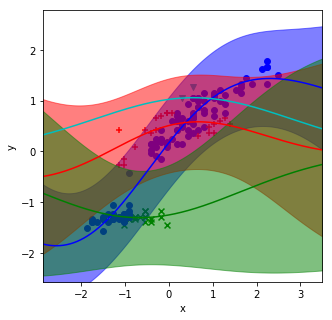

クラスタ数: 4
ARIの値: 0.051349695163116306
RMSEの値: [0.24017611091551308, 0.22223460782702356, 0.09067085013469516, 0.15298800258011977]
MAEの値: [0.4469649818675066, 0.43510246691843424, 0.26552899739278646, 0.33240995395576106]
r2scoreの値: [0.9432878485240055, 0.483069846349094, -0.1303658321477814, -0.8094805431611596]
実行時間: 9.156729698181152



  0%|          | 0/1 [00:00<?, ?it/s]

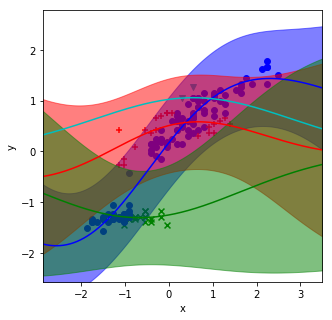

クラスタ数: 4
ARIの値: 0.051349695163116306
RMSEの値: [0.24017611091551308, 0.22223460782702356, 0.09067085013469516, 0.15298800258011977]
MAEの値: [0.4469649818675066, 0.43510246691843424, 0.26552899739278646, 0.33240995395576106]
r2scoreの値: [0.9432878485240055, 0.483069846349094, -0.1303658321477814, -0.8094805431611596]
実行時間: 9.150217533111572



In [19]:
#-------------------
def make_path(model,main_path):
    folder_name =  "クラスタ数" + str(model.n_cluster) + "ARI" + str(round(model.ARI ,4)) + "ラムダ" + str(round(model.lam,4)) + "アルファ" + str(round(model.alpha,4))+ "ノイズ" + str(model.D)
    my_makedirs(main_path + "/" + folder_name)
    return main_path + "/" + folder_name + "/"
#-------------------

#-------------------
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
#-------------------

def plot(x,y,x_name,y_name,path):
    plt.figure(figsize=(5,5))
    plt.plot(x,y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.tight_layout()
    plt.savefig(os.path.join(path) + x_name +  "-" + y_name +".png")
    plt.show()
#-------------------

#-------------------
def RMSE_plot(ex_list,list_name,ex_RMSE_list,path):
    N = 3
    #バグ防止用処置 回帰線が2個以下の場合
    for i in range(len(ex_RMSE_list)):
        if len(ex_RMSE_list[i]) < 3:
            N = 2
        if len(ex_RMSE_list[i]) < 2:
            N = 1
            
    RMSE_list = np.zeros([N,len(ex_list)])
    
    for i in range(N):
        for k in range(len(ex_list)):
            RMSE_list[i,k] = ex_RMSE_list[k][i]
        plot(ex_list,RMSE_list[:][i],list_name,"RMSE"+str(i+1),path)
#-------------------

#-------------------
def print_log(main_path,random_list,alpha,lam,D,ARI_list,ex_RMSE_list,ex_MAE_list,time_list):
    d_today = datetime.date.today()
    d_now = datetime.datetime.now() 
    
    ARI_mean = np.mean(ARI_list)
    ARI_std = np.std(ARI_list)
    time_mean = np.mean(time_list)
    time_std = np.std(time_list)
    
    #バグ防止用処置 回帰線が2個以下の場合
    N = 3
    for i in range(len(random_list)):
        if len(ex_RMSE_list[i]) < 3:
            N = 2
        if len(ex_RMSE_list[i]) < 2:
            N = 1
            
    RMSE_list = np.zeros([len(random_list),N])
    MAE_list = np.zeros([len(random_list),N])
    for i in range(len(random_list)):       
        for j in range(N):
            RMSE_list[i,j] = ex_RMSE_list[i][j]
            MAE_list[i,j] = ex_MAE_list[i][j]
  
    RMSE_means = np.mean(RMSE_list)
    RMSE_stds = np.std(RMSE_list)
    MAE_means = np.mean(MAE_list)
    MAE_means = np.std(MAE_list)
    
    f = open(main_path + "alpha" + str(alpha) + "lam" + str(lam) + "D" + str(D) + "ram" + str(random_list[0]) + "-" + str(random_list[len(random_list) -1 ]), 'w')
    f.write("実験に使用した記録まとめ\n")
    f.write(str(d_now) + "\n")
    f.write("seed値の数:" + str(len(random_list)) + "\n")
    f.write("ARIの平均:" + str(ARI_mean) + "\n")
    f.write("ARIの標準偏差：" + str(ARI_std) + "\n")
    f.write("1つ目の回帰線のRMSEの平均:" + str(np.mean(RMSE_list[:,0])) + "\n")
    f.write("1つ目の回帰線のRMSEの標準偏差:" + str(np.std(RMSE_list[:,0])) + "\n")
    f.write("2つ目の回帰線のRMSEの平均:" + str(np.mean(RMSE_list[:,1])) + "\n")
    f.write("2つ目の回帰線のRMSEの標準偏差:" + str(np.std(RMSE_list[:,1])) + "\n")
    f.write("1つ目の回帰線のMAEの平均:" +str(np.mean(MAE_list[:,0])) + "\n")
    f.write("1つ目の回帰線のMAEの標準偏差:" +str(np.std(MAE_list[:,0])) + "\n")
    f.write("2つ目の回帰線のMAEの平均:" + str(np.mean(MAE_list[:,1])) + "\n")
    f.write("2つ目の回帰線のMAEの標準偏差:" +str(np.std(MAE_list[:,1]))+ "\n")
    f.write("実行時間の平均:" + str(time_mean) + "\n")
    f.write("実行時間の標準偏差:" + str(time_std) + "\n")
    f.write("ノイズパラメータD:" + str(D) + "\n")
    f.write("カーネルパラメータα:" + str(alpha) + "\n")
    f.write("正則化パラメータλ:" + str(lam) +"\n")
    f.write("ARIリスト一覧：\n")
    f.write(str(ARI_list) + "\n")
    f.write("RMSEリスト一覧：\n")
    f.write(str(RMSE_list) + "\n")
    f.write("MAEリスト一覧：\n")
    f.write(str(MAE_list) + "\n")
    f.close()
#-------------------

#-------------------
def main():
    t_all = time.time()
   
    #------------
    #
    #alpha_list = np.linspace(0.0001,0.01, 100)
    #lam_list = np.linspace(0.01,1,100)
    #D_list = np.linspace(1.5,3,0.5)
    
    #alpha_list = np.arange(0.1,1,0.5)
    #lam_list = np.arange(0.1,2,0.1)
    #D_list = np.arange(1.1,1.5,0.1)
    #alpha_list = [0.01,0.01,0.1,1,3,7,10,30]
    alpha_list = [0.1]
    #lam_list = [0.0001,0.01,0.1,1,3,10,30]
    lam_list = [0.2]
    D_list = [2]
    #-----------
    #dataのパスを作成
    data_name = "iris_data"
    my_makedirs("./GPSCRM_result/" + data_name )
    my_makedirs("./GPSCRM_result/" + data_name + "/" + str(datetime.date.today()))
    main_path = "./GPSCRM_result/" + data_name + "/" + str(datetime.date.today())
    
    data = np.loadtxt("./data/"+ data_name +"/data.txt", dtype=float)
    X = data[:,0]
    Y = data[:,2]
    # X = data[0,:]
    # Y = data[1,:]
    labels = np.loadtxt("./data/"+ data_name +"/labels.txt")
    labels = np.array(labels)
    
    max_iter = 30
    ARI_list = []
    ex_RMSE_list = []
    
    ex_MAE_list = []
    time_list = []
    random_list = np.arange(0,100,1)
    
    for i in tqdm(range(len(random_list))):
        t1 = time.time()
        #ARI,RMSE_list,MAE = D_plot(X,Y,alpha_list,lam_list,D_list,labels,main_path,max_iter,random_list[i])
        ARI,RMSE_list,MAE_list = alpha_plot(X,Y,alpha_list,lam_list,D_list,labels,main_path,max_iter,random_list[i])
        #ARI,RMSE_list,MAE = lam_plot(X,Y,alpha_list,lam_list,D_list,labels,main_path,max_iter,random_list[i])
        t2 = time.time()
        ARI_list.append(ARI)
        ex_RMSE_list.append(RMSE_list[0])
        ex_MAE_list.append(MAE_list[0])
        time_list.append(t2-t1)
        
    
    print_log(main_path,random_list,alpha_list[0],lam_list[0],D_list[0],ARI_list,ex_RMSE_list,ex_MAE_list,time_list)
#-------------------

#-------------------
if __name__ == "__main__":
    main()
#-------------------